In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from apps import cex_toy_generator
from python.analysis import cross_section, Plots, Master

import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd

from rich import print

cross_section.SetPlotStyle(True, dpi = 140)

def truth_regions(events : Master.Data) -> dict:
    """ masks to select particle which interact in a particular channel or "region". these truth regions reflect the channels defined in the simulation.

    Args:
        events (Master.Data): events to look at.

    Returns:
        dict: dictionary of masks.
    """
    inelastic = events.trueParticles.true_beam_endProcess == "pi+Inelastic"
    absorption = inelastic & (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 0)
    cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 1) & (events.trueParticles.nPiMinus == 0)
    quasielastic = (events.trueParticles.nPiPlus == 1) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 0)
    double_cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 1)
    pion_production = inelastic & (~absorption) & (~cex) & (~quasielastic) & ~(double_cex)
    return {"total_inelastic" : inelastic, "absorption" : absorption, "charge_exchange" : cex, "quasielastic" : quasielastic, "double_charge_exchange" : double_cex, "pion_production" : pion_production}


def LoadSample(file : str, nEvents : int) -> Master.Data:
    """ Load root file and select only true pions.

    Args:
        file (str): root file
        nEvents (int): number of events

    Returns:
        Master.Data: true pion events
    """
    events = Master.Data(file, nTuple_type = Master.Ntuple_Type.PDSP, nEvents = nEvents)

    mask = events.trueParticles.pdg[:, 0] == 211
    events.Filter([mask], [mask])
    return events


def CreateMasks(toy : pd.DataFrame) -> dict: #? move to toy generator?
    """ Creates masks for each inclusive process and exclusive process based on particle tags from the toy mc.

    Args:
        toy (pd.DataFrame): toy mc to look at

    Returns:
        dict: masks of processes
    """
    masks = {}
    for c in np.unique(toy.exclusive_process)[1:]:
        masks[c] = toy.exclusive_process == c
    for c in np.unique(toy.inclusive_process)[1:]:
        masks[c] = toy.inclusive_process == c
    return masks

In [2]:
toy_single = pd.read_hdf("work/2023/toys/xs_toy_1GeV_single.hdf5")
toy_gaussian = pd.read_hdf("work/2023/toys/xs_toy_1GeV_gaussian_60_MeV.hdf5")
mc = LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", -1)
geant_xs = cross_section.GeantCrossSections(energy_range = [0, 1000])

masks_single = CreateMasks(toy_single)
masks_gaussian = CreateMasks(toy_gaussian)
regions = truth_regions(mc) # get truth regions

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


In [18]:
save = True
if save: pdf = PdfPages("xs_toy.pdf")
def Save():
    if save:
        try:
            pdf.savefig()
        except AttributeError:
            pass

For the toy simulation we need to generate:
 - $KE_{init}$ : initial kinetic energy
 - $KE_{int}$ : interacting kinetic energy
 - $z_{int}$ : 1D interacting vertex

The toy will simulate particles in an infinite volume of LAr, so there is no end of the detector or upstream loss to consider.

To generate $KE_{init}$ any PDF can be used, if we want to mimic the ProtoDUNE SP beam profile we can extract values from $KE^{true}_{init}$.
To genrate $KE_{int}$ and $z_{int}$, we can sample from a pdf which represents the probability of interacting with LAr. The probability of a particle interacting in a medium is related to the mean free path ($\lambda(E)$) of that material and it's path length distribution:

### $$ P_{int}(E, l) = \int^{l}_{0} p(E, l')dl' = \int^{l}_{0} \frac{1}{\lambda(E)} e^{-\frac{l'}{\lambda(E)}} dl' = 1 - e^{-\frac{l}{\lambda(E)}};\; \lambda(E) = \frac{M_{Ar}}{\sigma(E)N_{A}\rho} $$

### $$ \therefore P_{int}(E, l) = 1 - e^{-\sigma(E)\frac{N_{A}\rho l}{M_{Ar}}} $$

So for thin and energy slice measurements $l$ is the spatial slice thickness, but for the toy model, this is our sampling rate i.e. how often do we check if a particle has interacted. Particles loose energy as they travel through a medium, so whilst checking if the particle has interacted, we must compute the enegy lost by the particle as it travels a distance $l$, so use the bethe bloch formula for this:

### $$ E_{i + 1} = E_{i} - l \left< \frac{dE}{dX} \right>_{bb}(E_{i}) $$

The simulation procedure will be as follows (using rejection sampling to figure out if the particle interacted):
 1. Generate $KE_init$, set particle $KE_{int} = KE_{init}$ and distance travelled $dz_{int} = 0$
 2. Generate a random number from a uniform distribution U
 3. Find $P_{int}(KE_{int})$
 4. If $U < P_{int}(KE_{int})$ stop here, otherwise go to step 5
 5. Update $KE_{int}$ using the bethe bloch formula, update distsance travelled $z_{int} + l$, repeat from step 1.

if the particle Kinetic energy is zero, stop and assume it has decayed.

This is for one cross section $\sigma$ but a particle can interact in multiple distinguished ways, so rather than having one PDF for interactions we must sample from multiple to figure out which one occured. For a total inelastic cross section, we do the following (pcking up from step 4):

 5. For each cross section channel $j$ check $U < P^{j}_{int}(KE_{int})$, if this is true, stop otherwise try the next channel. If this is not true for all channels stop.

The PDFs themselves must also be created. From the Geant4 simulation we have plots which represent $\sigma(KE)$ but we do not have the exact formula, so an "emperical" formula is made by using interpolation. This constrains the toy from only being able to model cross sections for particles within the energy ranges defined by the Geant4 cross section plots.

[
    ('double_charge_exchange', 1.9741367359892672),
    ('charge_exchange', 4.77876530079023),
    ('absorption', 8.493801365774498),
    ('quasielastic', 19.104487076845135),
    ('pion_production', 54.509618371959625)
]

{
    'total_inelastic': <scipy.interpolate._interpolate.interp1d object at 0x7f34310860c0>,
    'double_charge_exchange': <scipy.interpolate._interpolate.interp1d object at 0x7f3433283510>,
    'charge_exchange': <scipy.interpolate._interpolate.interp1d object at 0x7f3433ed6d90>,
    'absorption': <scipy.interpolate._interpolate.interp1d object at 0x7f3433ed5120>,
    'quasielastic': <scipy.interpolate._interpolate.interp1d object at 0x7f3428be8ef0>,
    'pion_production': <scipy.interpolate._interpolate.interp1d object at 0x7f3428be8b80>
}

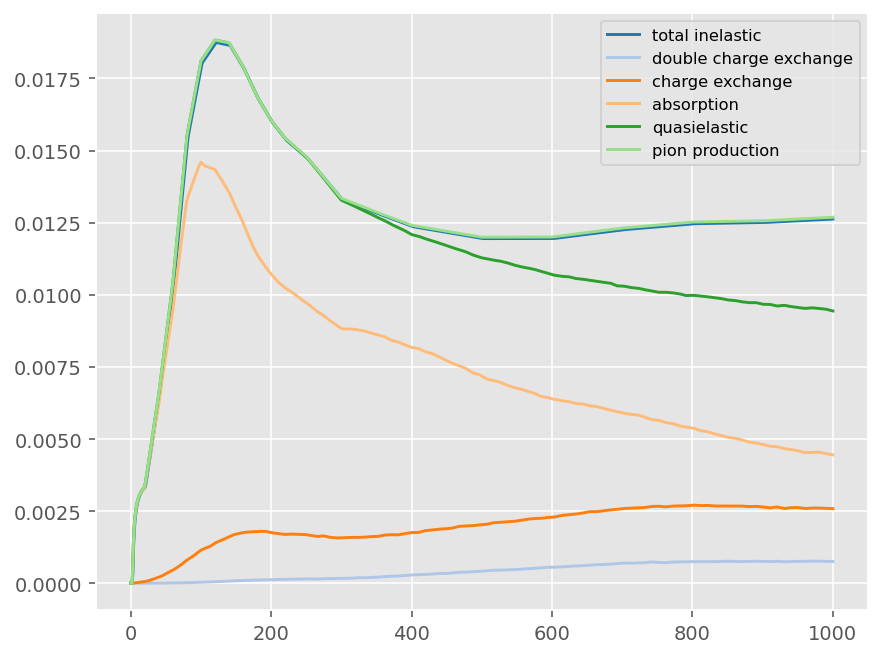

In [19]:
pdfs = cex_toy_generator.GenerateStackedPDFs(2)

x = np.linspace(0, 1E3, 1000)
for p in pdfs:
    Plots.Plot(x, pdfs[p](x), newFigure = False, label = p.replace("_", " "))
Save()

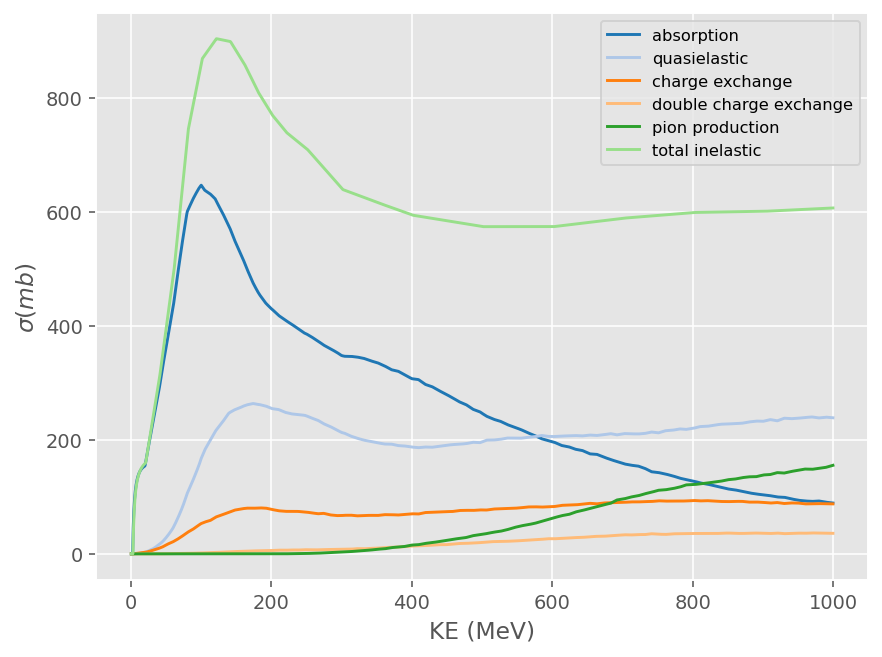

In [20]:
geant_xs.Plot("all")
Save()

# Thin slice method

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:555: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:557: RuntimeWarning: invalid value encountered in divide
  std_energy = np.divide(sum_energy_sqr, counts) - mean_energy**2


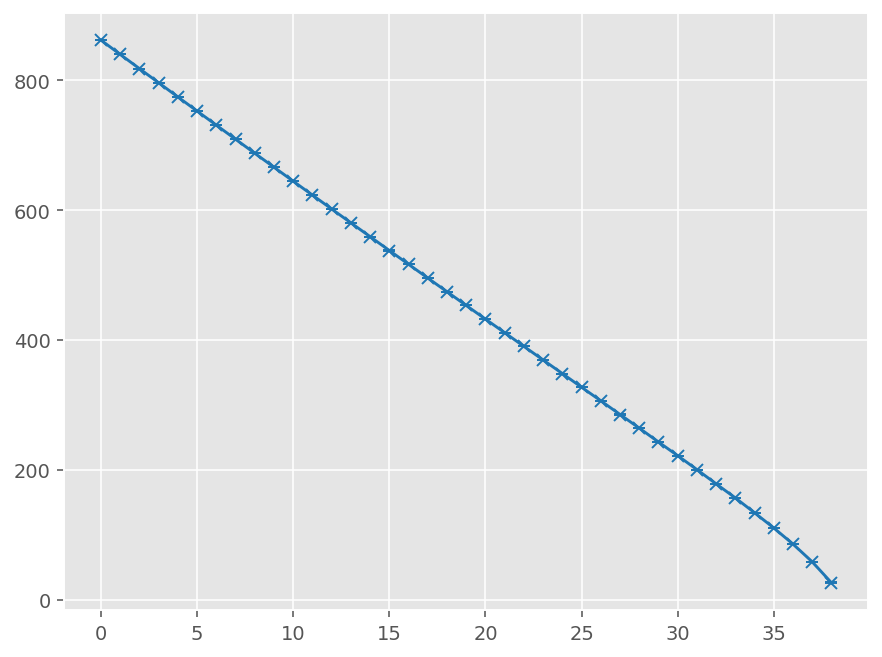

In [21]:
slices = cross_section.Slices(10, -10, 720)
mean_energy = cross_section.ThinSlice.MeanSliceEnergy(toy_single.KE_int[masks_single["total_inelastic"]], toy_single.z_int[masks_single["total_inelastic"]], slices)

Plots.Plot(slices.num[:-1], mean_energy[0], marker = "x", yerr = mean_energy[1])

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:575: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:578: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:580: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5


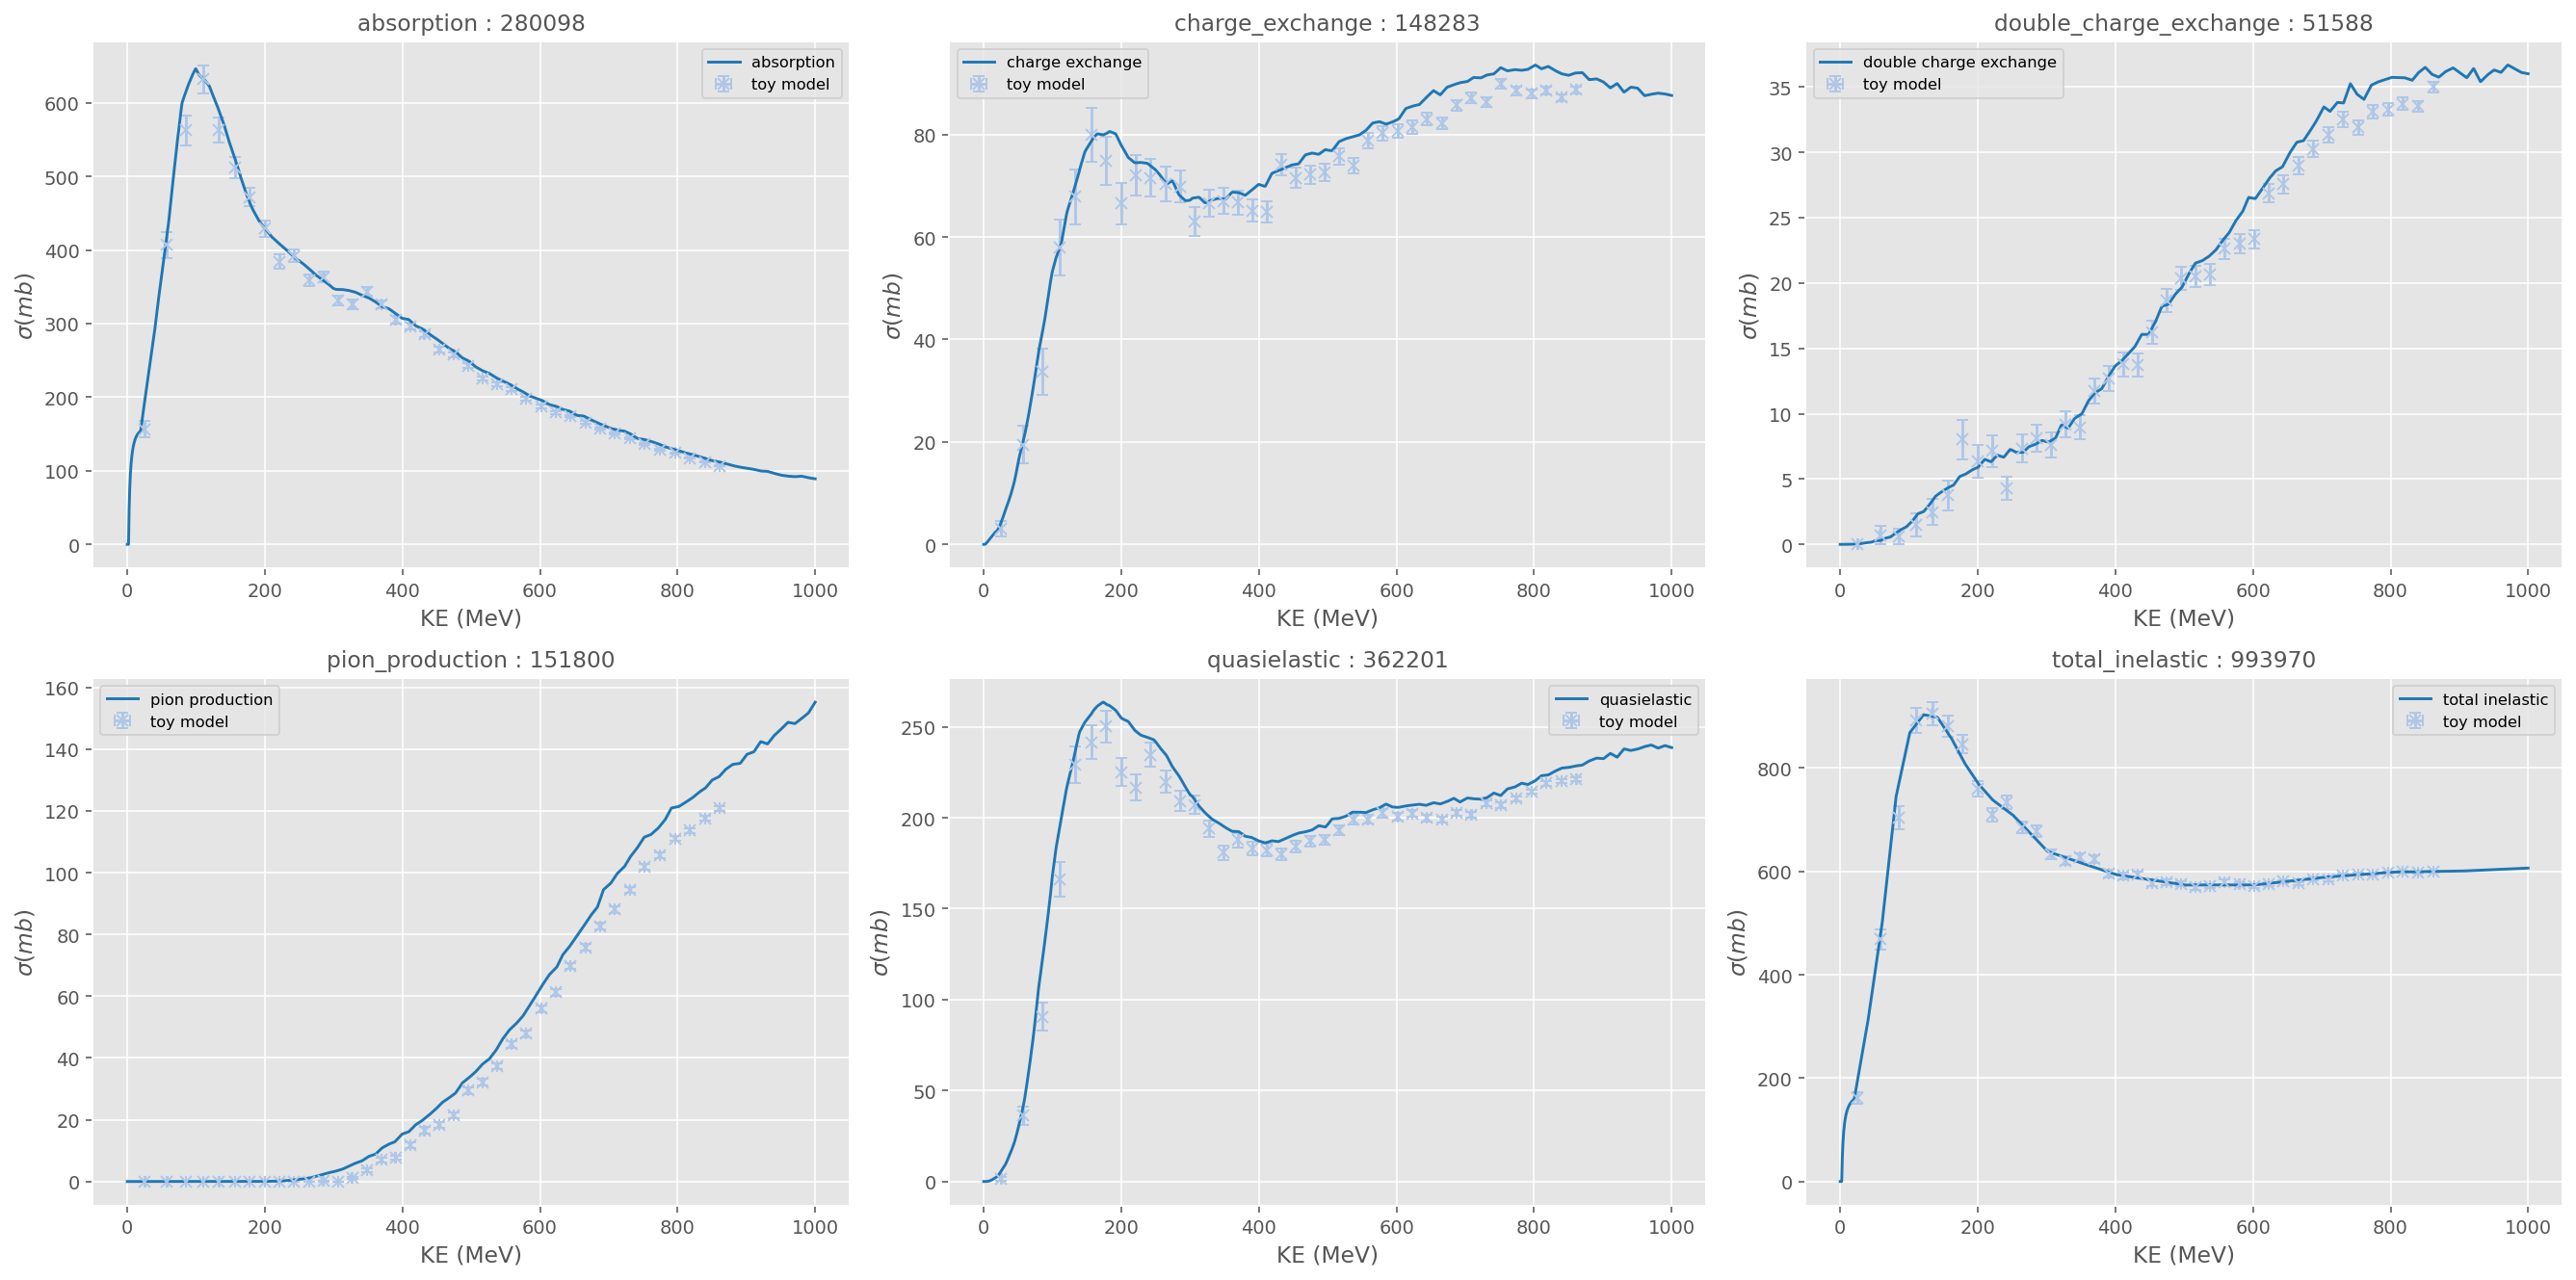

In [22]:
for i, c in Plots.IterMultiPlot(masks_single, sharex = True):
    n_interact, n_incident = cross_section.ThinSlice.CountingExperiment(toy_single.z_int, masks_single[c], slices)
    xs = cross_section.ThinSlice.CrossSection(n_incident, n_interact, slices.width)

    geant_xs.Plot(c)
    Plots.Plot(mean_energy[0], xs[0], xerr = mean_energy[1], yerr = xs[1], marker = "x", linestyle = "", newFigure = False, label = "toy model", title = f"{c} : {sum(masks_single[c])}")
# Plots.plt.ylim(0, 2000)

# Energy Slice Method

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:158: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:575: RuntimeWarning: invalid value encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section


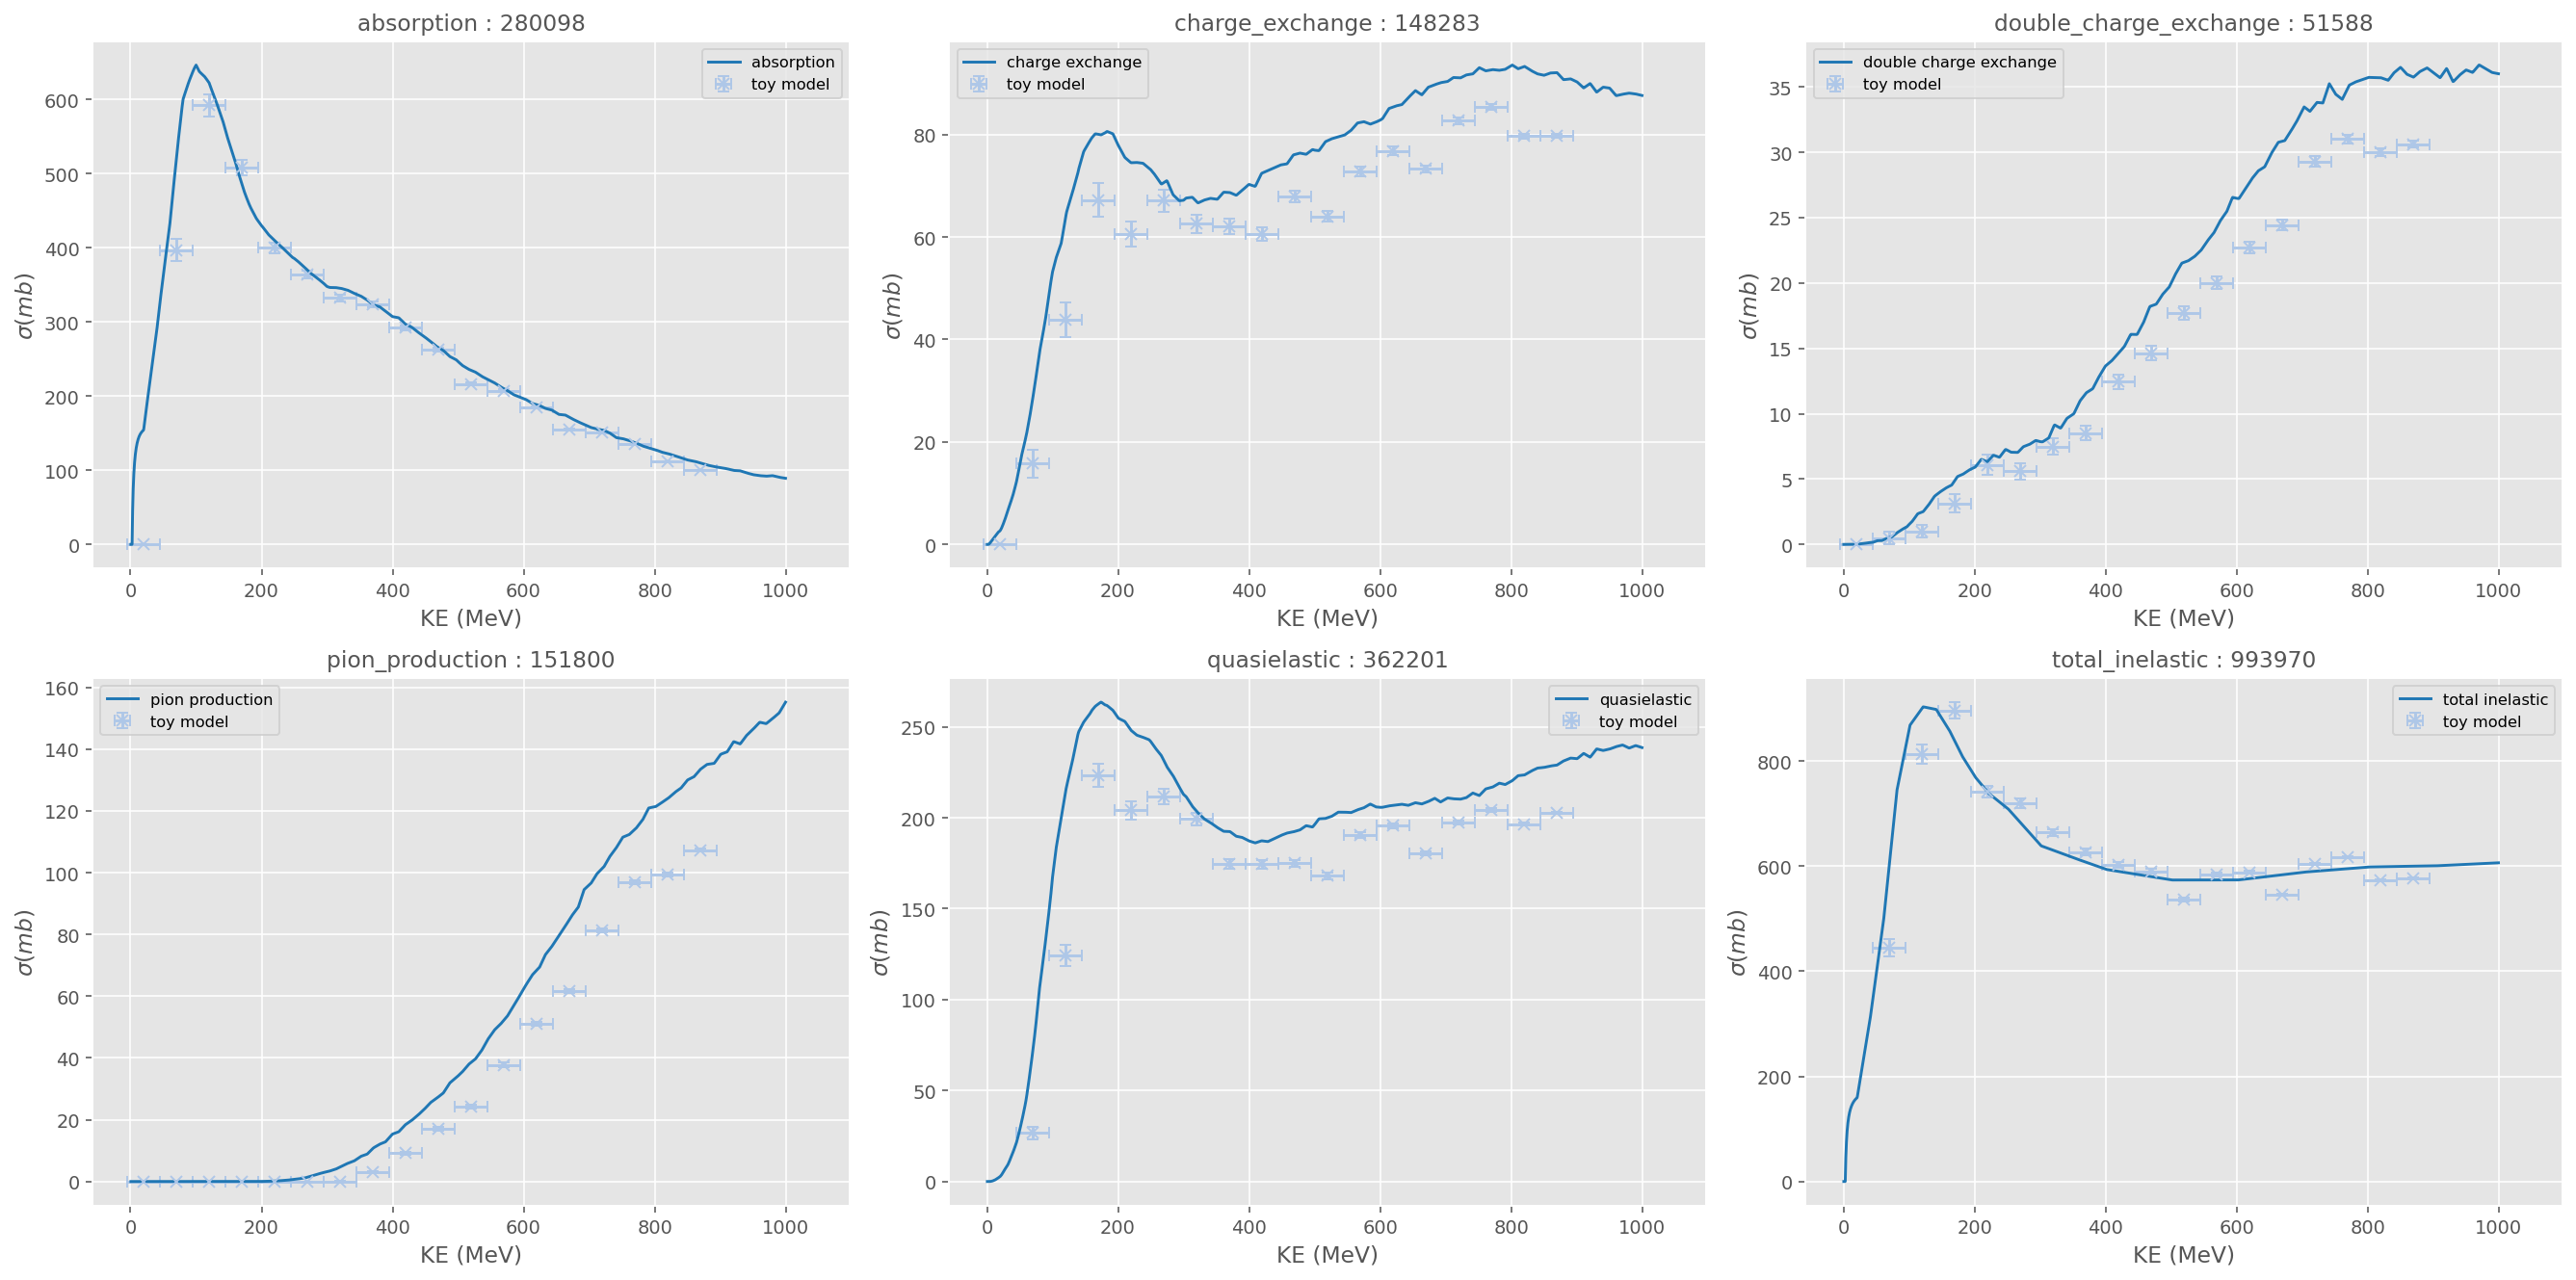

In [23]:
energy_slices = cross_section.Slices(50, 0, 1020, reversed = True)
slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))

for i, c in Plots.IterMultiPlot(masks_single, sharex = True):
    n_interact, n_incident = cross_section.EnergySlice.CountingExperiment(toy_single.KE_int, toy_single.KE_init, toy_single.z_int < 0, masks_single[c], energy_slices)
    xs = cross_section.EnergySlice.CrossSection(n_interact, n_incident, slice_dEdX, energy_slices.width)

    geant_xs.Plot(c)
    Plots.Plot(energy_slices.pos, xs[0], xerr = energy_slices.width/2, yerr = xs[1], marker = "x", linestyle = "", newFigure = False, label = "toy model", title = f"{c} : {sum(masks_single[c])}")


In [1]:
def Effective_distance():
    """ Plot effective distance for the enregy slice method, for a given set of slice thicknesses
    """
    widths = [10, 25, 50, 75, 100]
    for w in widths:
        energy_slices = cross_section.Slices(w, 0, 1000, reversed = True)
        slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))
        Plots.Plot(energy_slices.pos, energy_slices.width / slice_dEdX, xlabel = "slice KE (MeV)", ylabel = "effictive distance (cm)", newFigure = False, label = f"{w}MeV")

Effective_distance()
plt.axhline(2, color = "black", linestyle = "--", label = "simulation step size (cm)")
plt.legend()
Save()

NameError: name 'cross_section' is not defined

# Comparing to MC truth

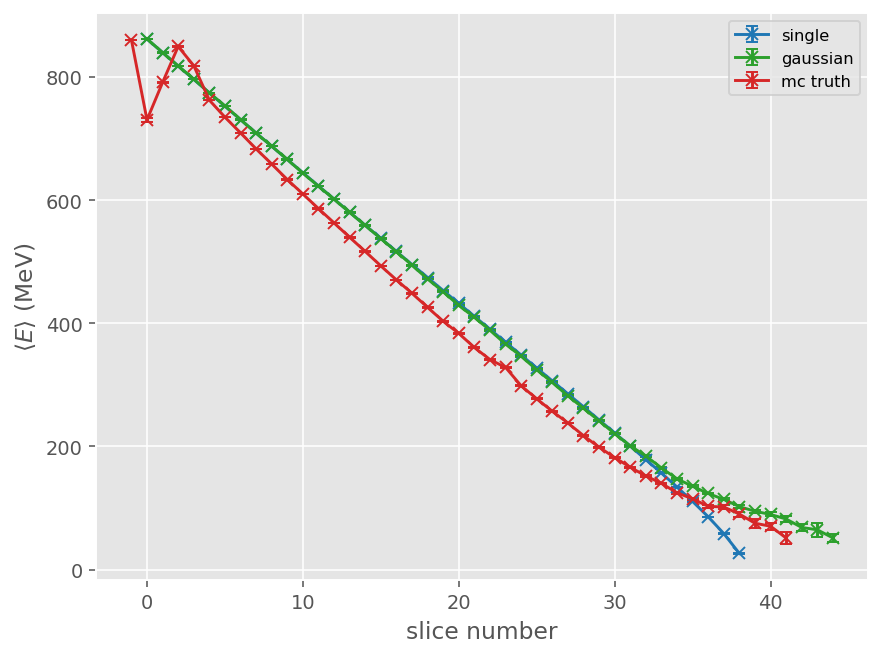

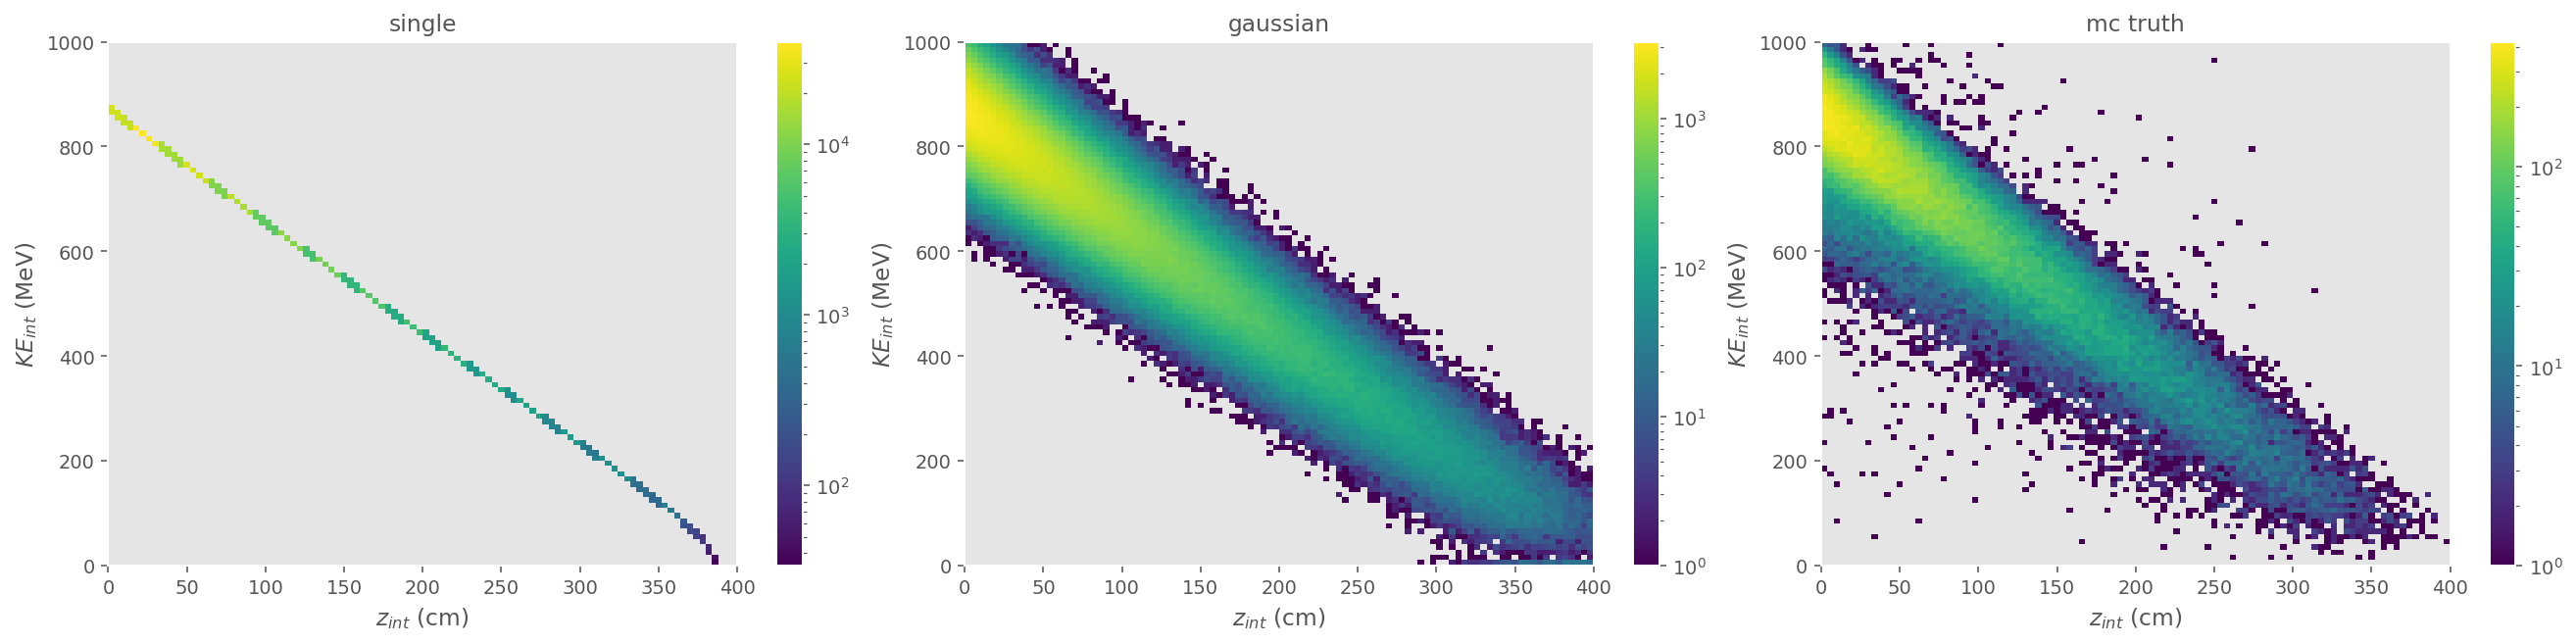

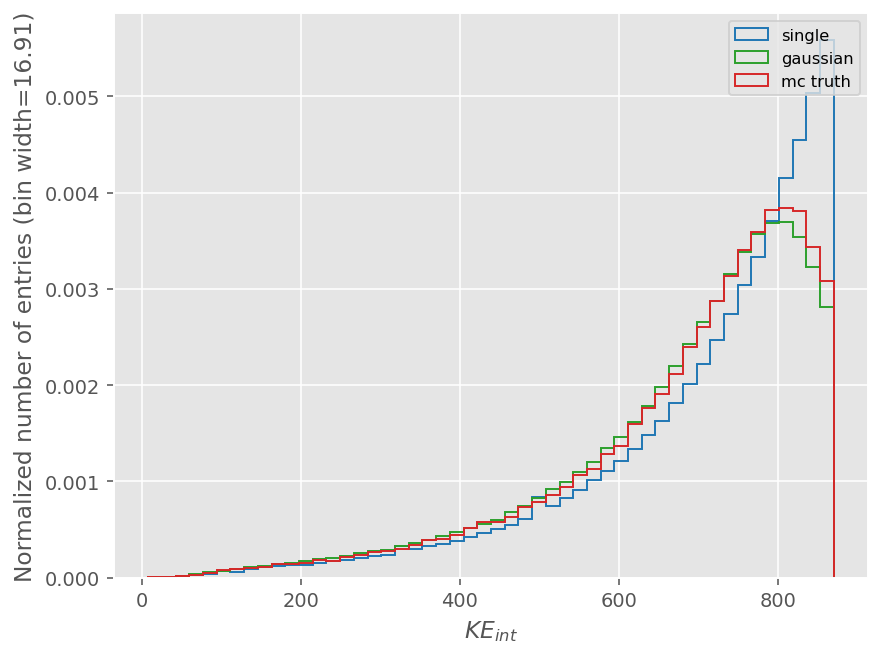

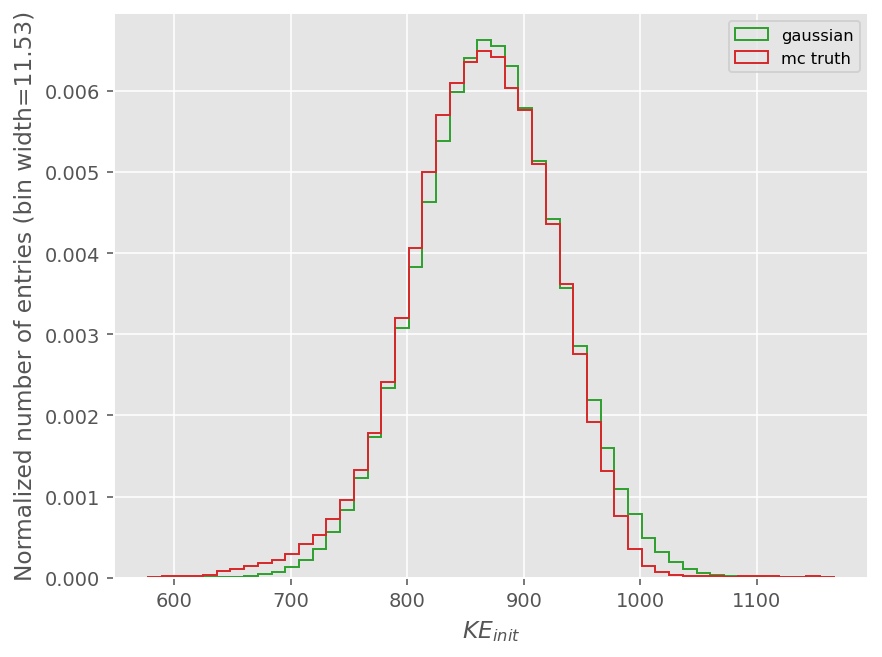

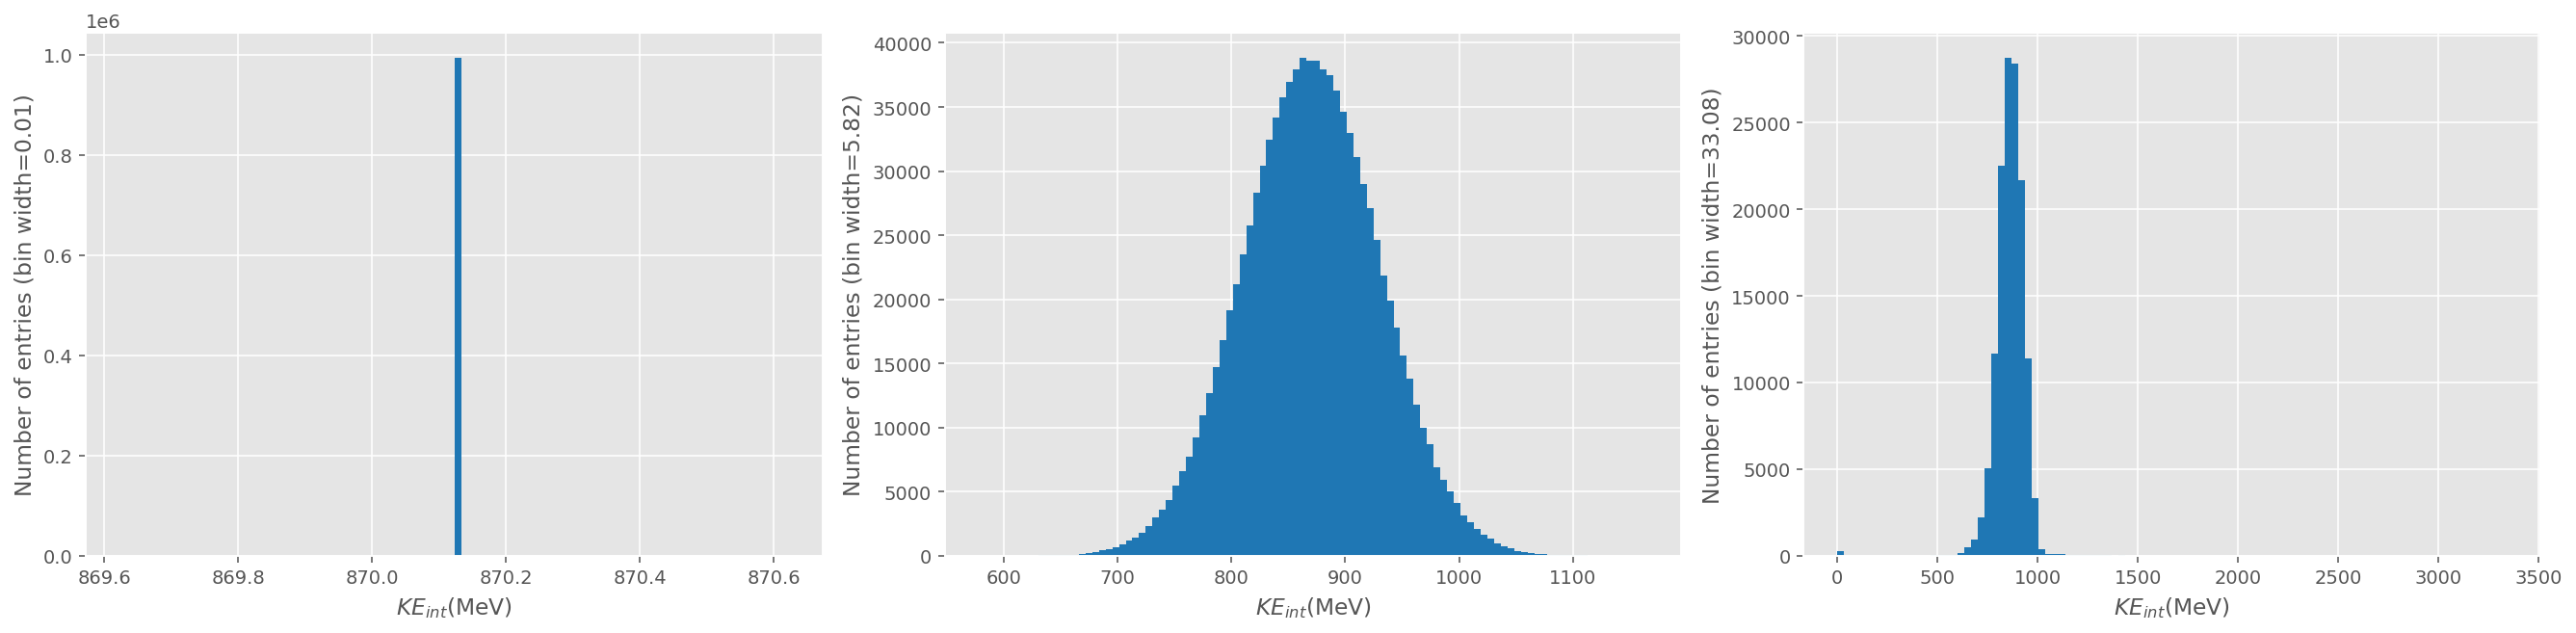

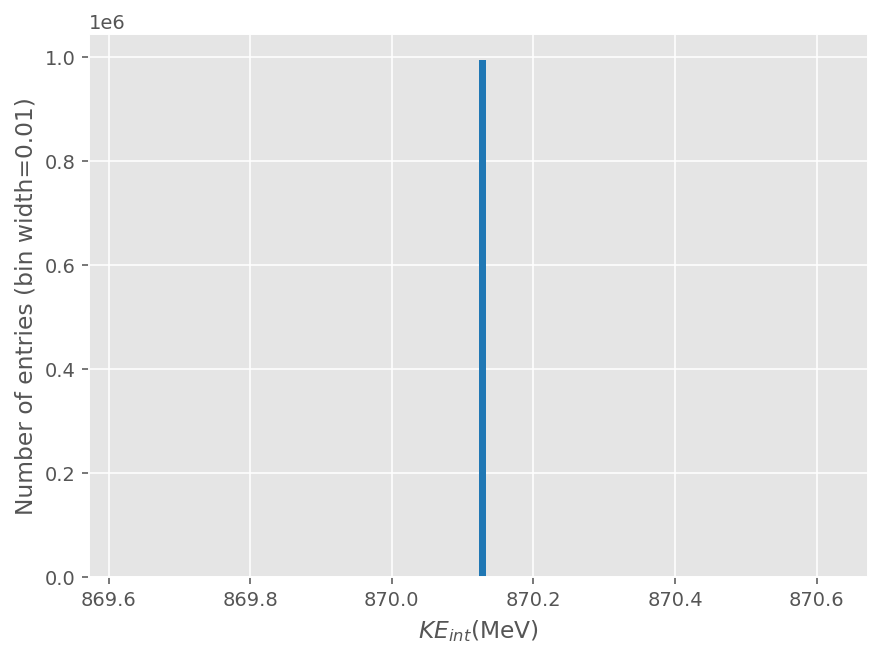

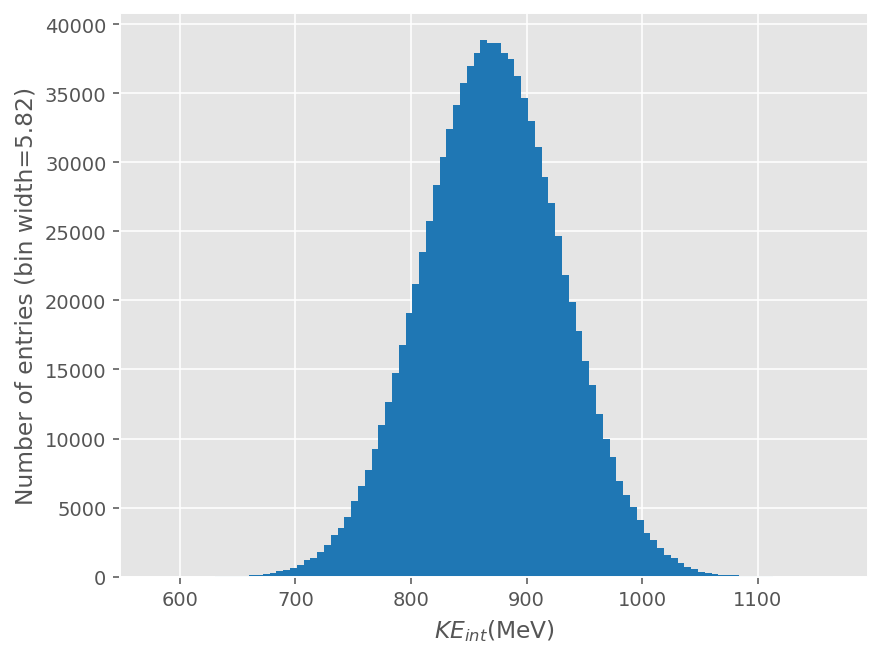

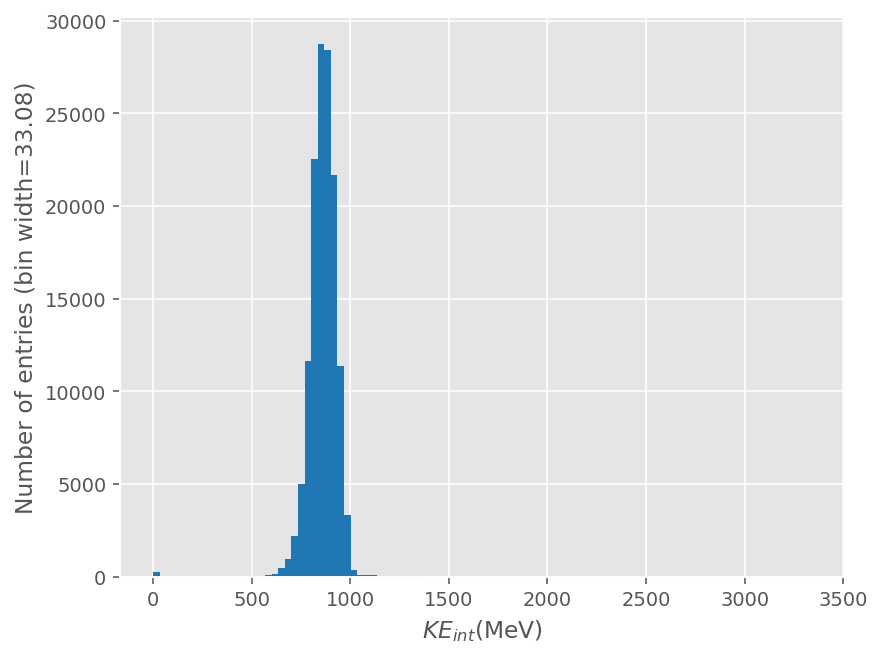

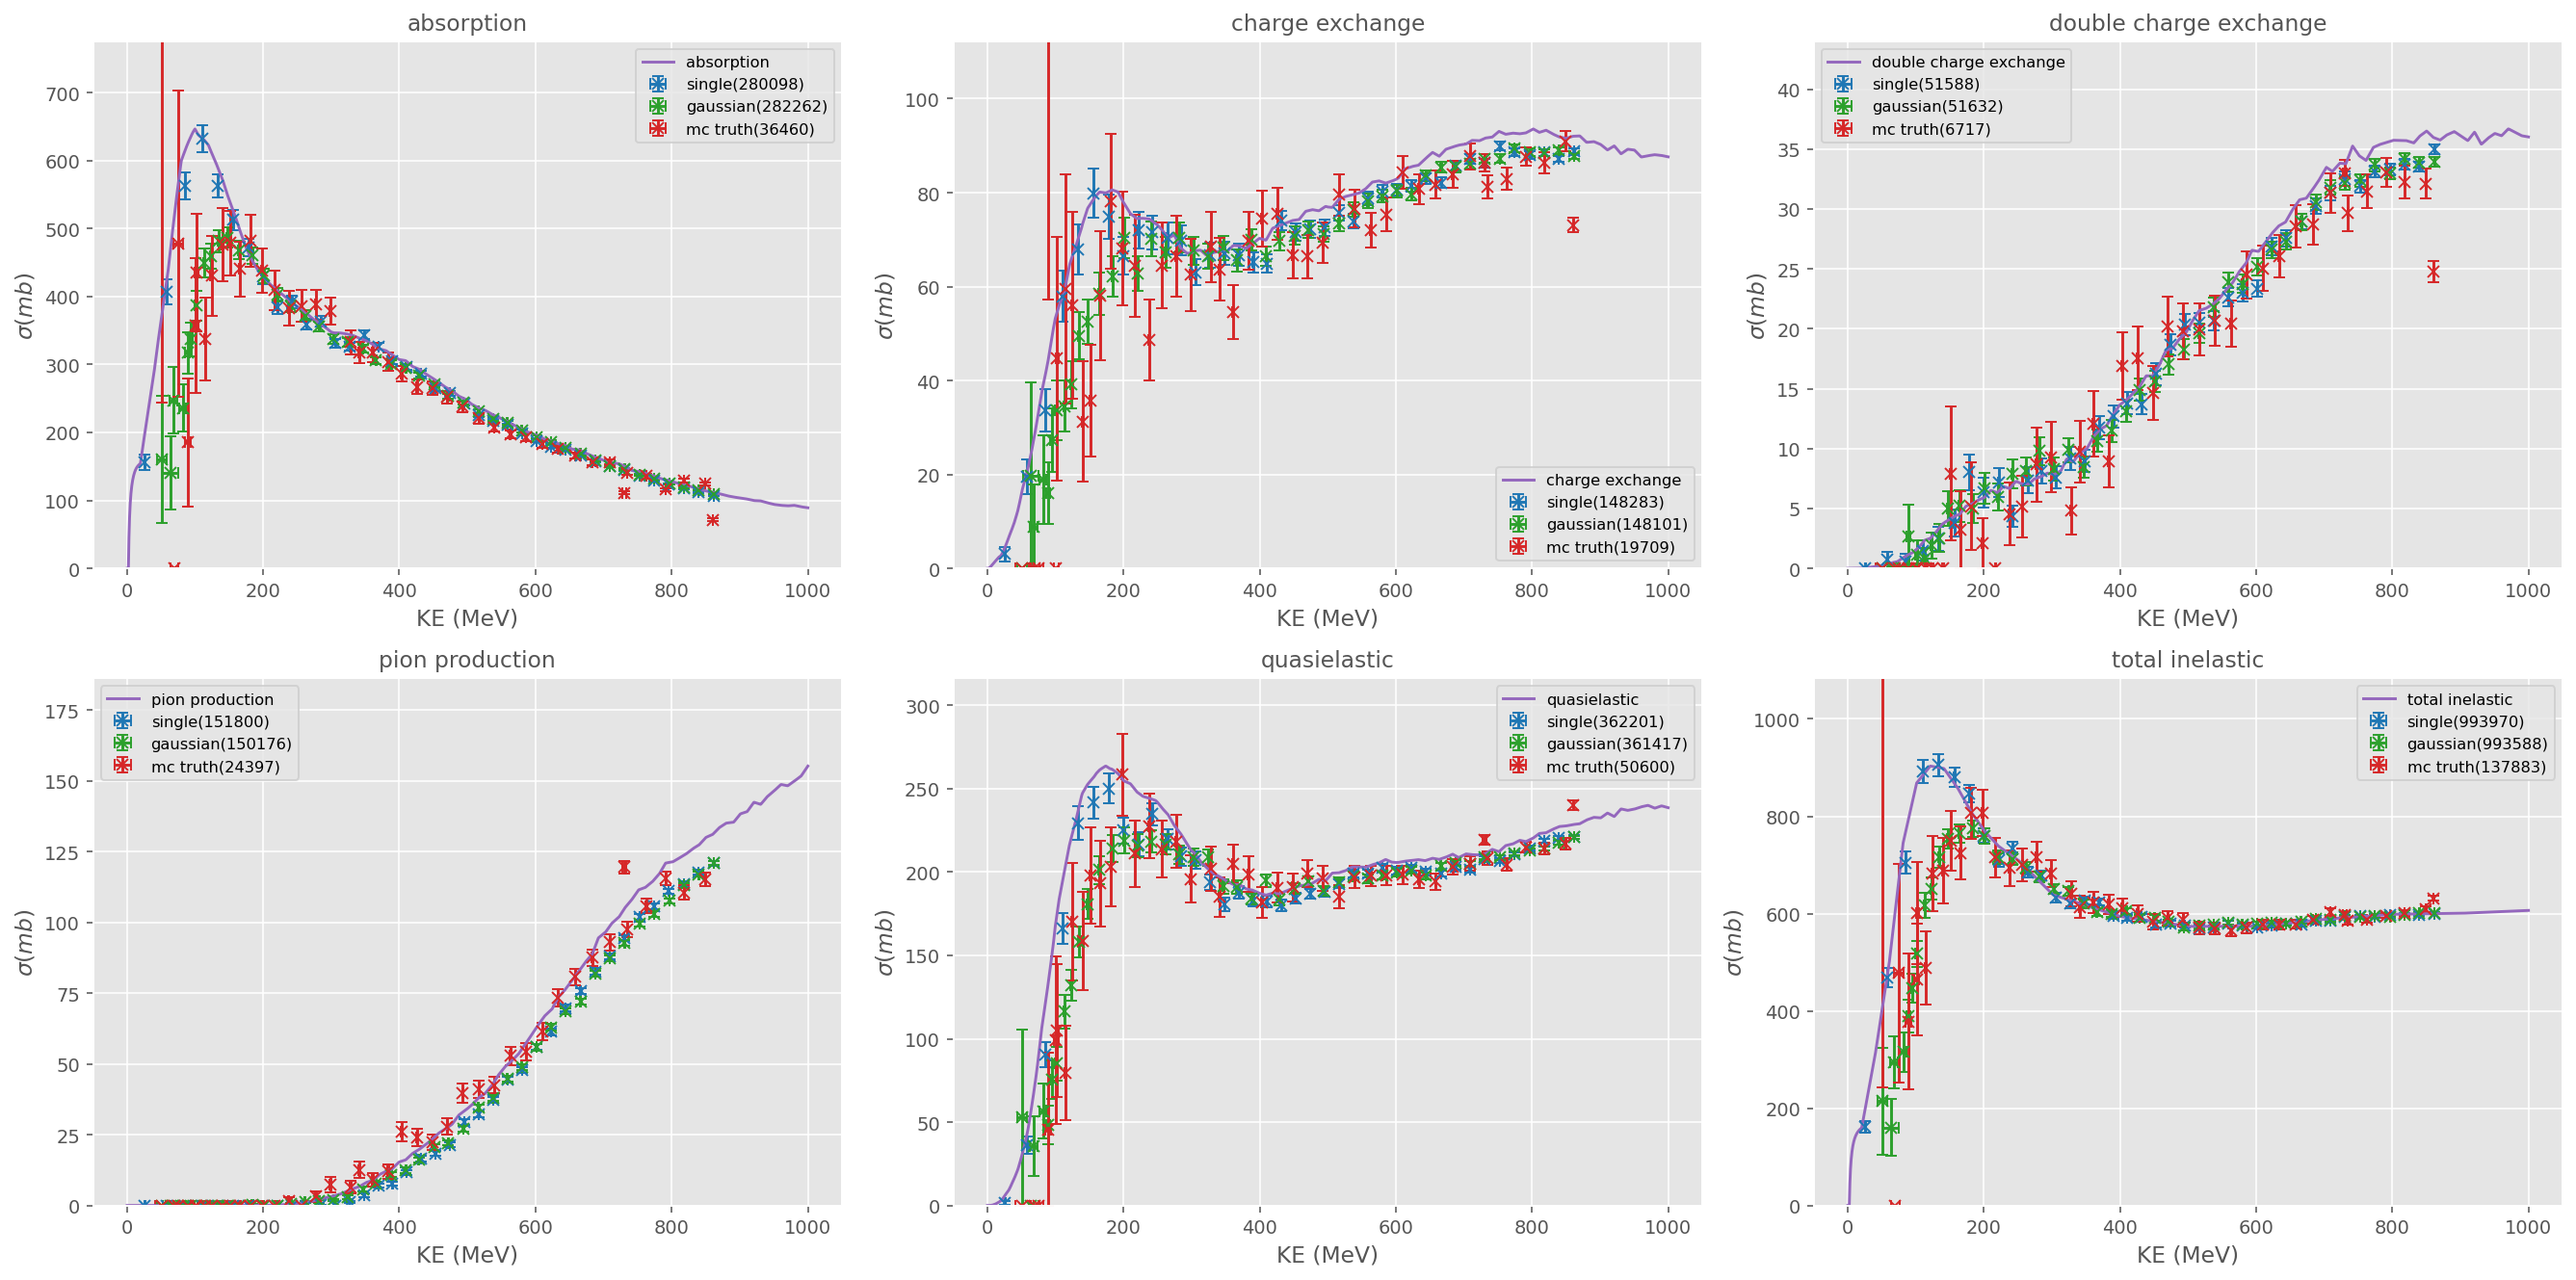

In [25]:
def ThinSliceComparison(slice_width : float, position_range : list):
    """ Compares thin slice method for the single profile toy, gaussian profile toy and mc truth.

    Args:
        slice_width (float): spatial slice width (cm)
        position_range (list): min, max position for slices (cm)
    """
    slices = cross_section.Slices(slice_width, min(position_range), max(position_range))

    interact_position = mc.trueParticles.endPos.z[:, 0] # get interaction vertex z position

    traj_KE = mc.trueParticles.beam_traj_KE # get beam particle kinetic energy at each trajectory point from simulation
    traj_pos = mc.trueParticles.beam_traj_pos.z # get beam particle z at each trajectory point from simulation 

    colours = {
        "single"   : "C0",
        "gaussian" : "C4",
        "mc truth" : "C6"
    }

    mean_energies = {}
    mean_energies["single"] = cross_section.ThinSlice.MeanSliceEnergy(toy_single.KE_int[masks_single["total_inelastic"]], toy_single.z_int[masks_single["total_inelastic"]], slices)
    mean_energies["gaussian"] = cross_section.ThinSlice.MeanSliceEnergy(toy_gaussian.KE_int[masks_gaussian["total_inelastic"]], toy_gaussian.z_int[masks_gaussian["total_inelastic"]], slices)
    mean_energies["mc truth"] = cross_section.ThinSlice.MeanSliceEnergy(traj_KE[regions["total_inelastic"]], traj_pos[regions["total_inelastic"]], slices)

    for l, v in mean_energies.items():
        Plots.Plot(slices.num[:-2], v[0][:-1], marker = "x", yerr = v[1][:-1], label = l, xlabel = "slice number", ylabel = "$\left< E \\right>$ (MeV)", newFigure = False, color = colours[l])
    Save()

    z_int = {
        "single"   : toy_single.z_int[masks_single["total_inelastic"]],
        "gaussian" : toy_gaussian.z_int[masks_single["total_inelastic"]],
        "mc truth" : interact_position[regions["total_inelastic"]]
    }
    KE_int = {
        "single"   : toy_single.KE_int[masks_single["total_inelastic"]],
        "gaussian" : toy_gaussian.KE_int[masks_single["total_inelastic"]],
        "mc truth" : traj_KE[:, -2][regions["total_inelastic"]]
    }

    for _, d in Plots.IterMultiPlot(list(z_int.keys()), sharex = True, sharey = True):
        Plots.PlotHist2D(z_int[d], KE_int[d], xlabel = "$z_{int}$ (cm)", ylabel = "$KE_{int}$ (MeV)", title = d, newFigure = False, x_range = [0, 400], y_range = [0, 1000])
    Save()

    Plots.PlotHistComparison([toy_single.KE_int[masks_single["total_inelastic"]], toy_gaussian.KE_int[masks_gaussian["total_inelastic"]], traj_KE[:, -2][regions["total_inelastic"]]], labels = list(mean_energies.keys()), bins = 50, colours = list(colours.values()), xlabel = "$KE_{int}$")
    Save()
    Plots.PlotHistComparison([toy_gaussian.KE_init[masks_gaussian["total_inelastic"]], mc.trueParticles.KE_front_face[regions["total_inelastic"]]], labels = ["gaussian", "mc truth"], bins = 50, colours = [colours["gaussian"], colours["mc truth"]], xlabel = "$KE_{init}$")
    Save()
    
    for i, d in Plots.IterMultiPlot([toy_single.KE_init[masks_single["total_inelastic"]], toy_gaussian.KE_init[masks_gaussian["total_inelastic"]], mc.trueParticles.KE_front_face[regions["total_inelastic"]]]):
        Plots.PlotHist(d, xlabel = "$KE_{int}$(MeV)", newFigure = False)
    Save()
    for d in [toy_single.KE_init[masks_single["total_inelastic"]], toy_gaussian.KE_init[masks_gaussian["total_inelastic"]], mc.trueParticles.KE_front_face[regions["total_inelastic"]]]:
        Plots.PlotHist(d, xlabel = "$KE_{int}$(MeV)")
        Save()

    for _, c in Plots.IterMultiPlot(masks_single, sharex = True):
        hists = {}
        hists["single"] = cross_section.ThinSlice.CountingExperiment(toy_single.z_int, masks_single[c], slices)
        hists["gaussian"] = cross_section.ThinSlice.CountingExperiment(toy_gaussian.z_int, masks_gaussian[c], slices)
        hists["mc truth"] = cross_section.ThinSlice.CountingExperiment(interact_position, regions[c], slices)

        counts = {
            "single" : sum(masks_single[c]),
            "gaussian" : sum(masks_gaussian[c]),
            "mc truth" : sum(regions[c])
        }

        geant_xs.Plot(c, color = "C8")
        for h in hists:
            if h == "mc truth": # needed because beam particle travel through the TPC in an angle
                attenuation = 0.95
            else:
                attenuation = 1
            xs = cross_section.ThinSlice.CrossSection(hists[h][1], hists[h][0], slices.width / attenuation)
            Plots.Plot(mean_energies[h][0], xs[0], xerr = mean_energies[h][1], yerr = xs[1], marker = "x", linestyle = "", newFigure = False, label = f"{h}({counts[h]})", title = c.replace("_", " "), color = colours[h])
        plt.ylim(0, 1.2 * max(getattr(geant_xs, c)))
    Save()
    return

ThinSliceComparison(10, [-10, 720])

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:161: RuntimeWarning: divide by zero encountered in divide
  N = np.divide((BetheBloch.rho * BetheBloch.K * BetheBloch.Z * (particle.charge)**2), (BetheBloch.A * (beta**2)))
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:162: RuntimeWarning: divide by zero encountered in log
  A = 0.5 * np.log(2 * BetheBloch.me * (gamma**2) * (beta**2) * w_max / ((BetheBloch.I) **2))
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:137: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(beta * gamma)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:140: RuntimeWarning: invalid value encountered in add
  delta_1 = delta_0 + BetheBloch.a * (BetheBloch.y1 - y)**BetheBloch.k


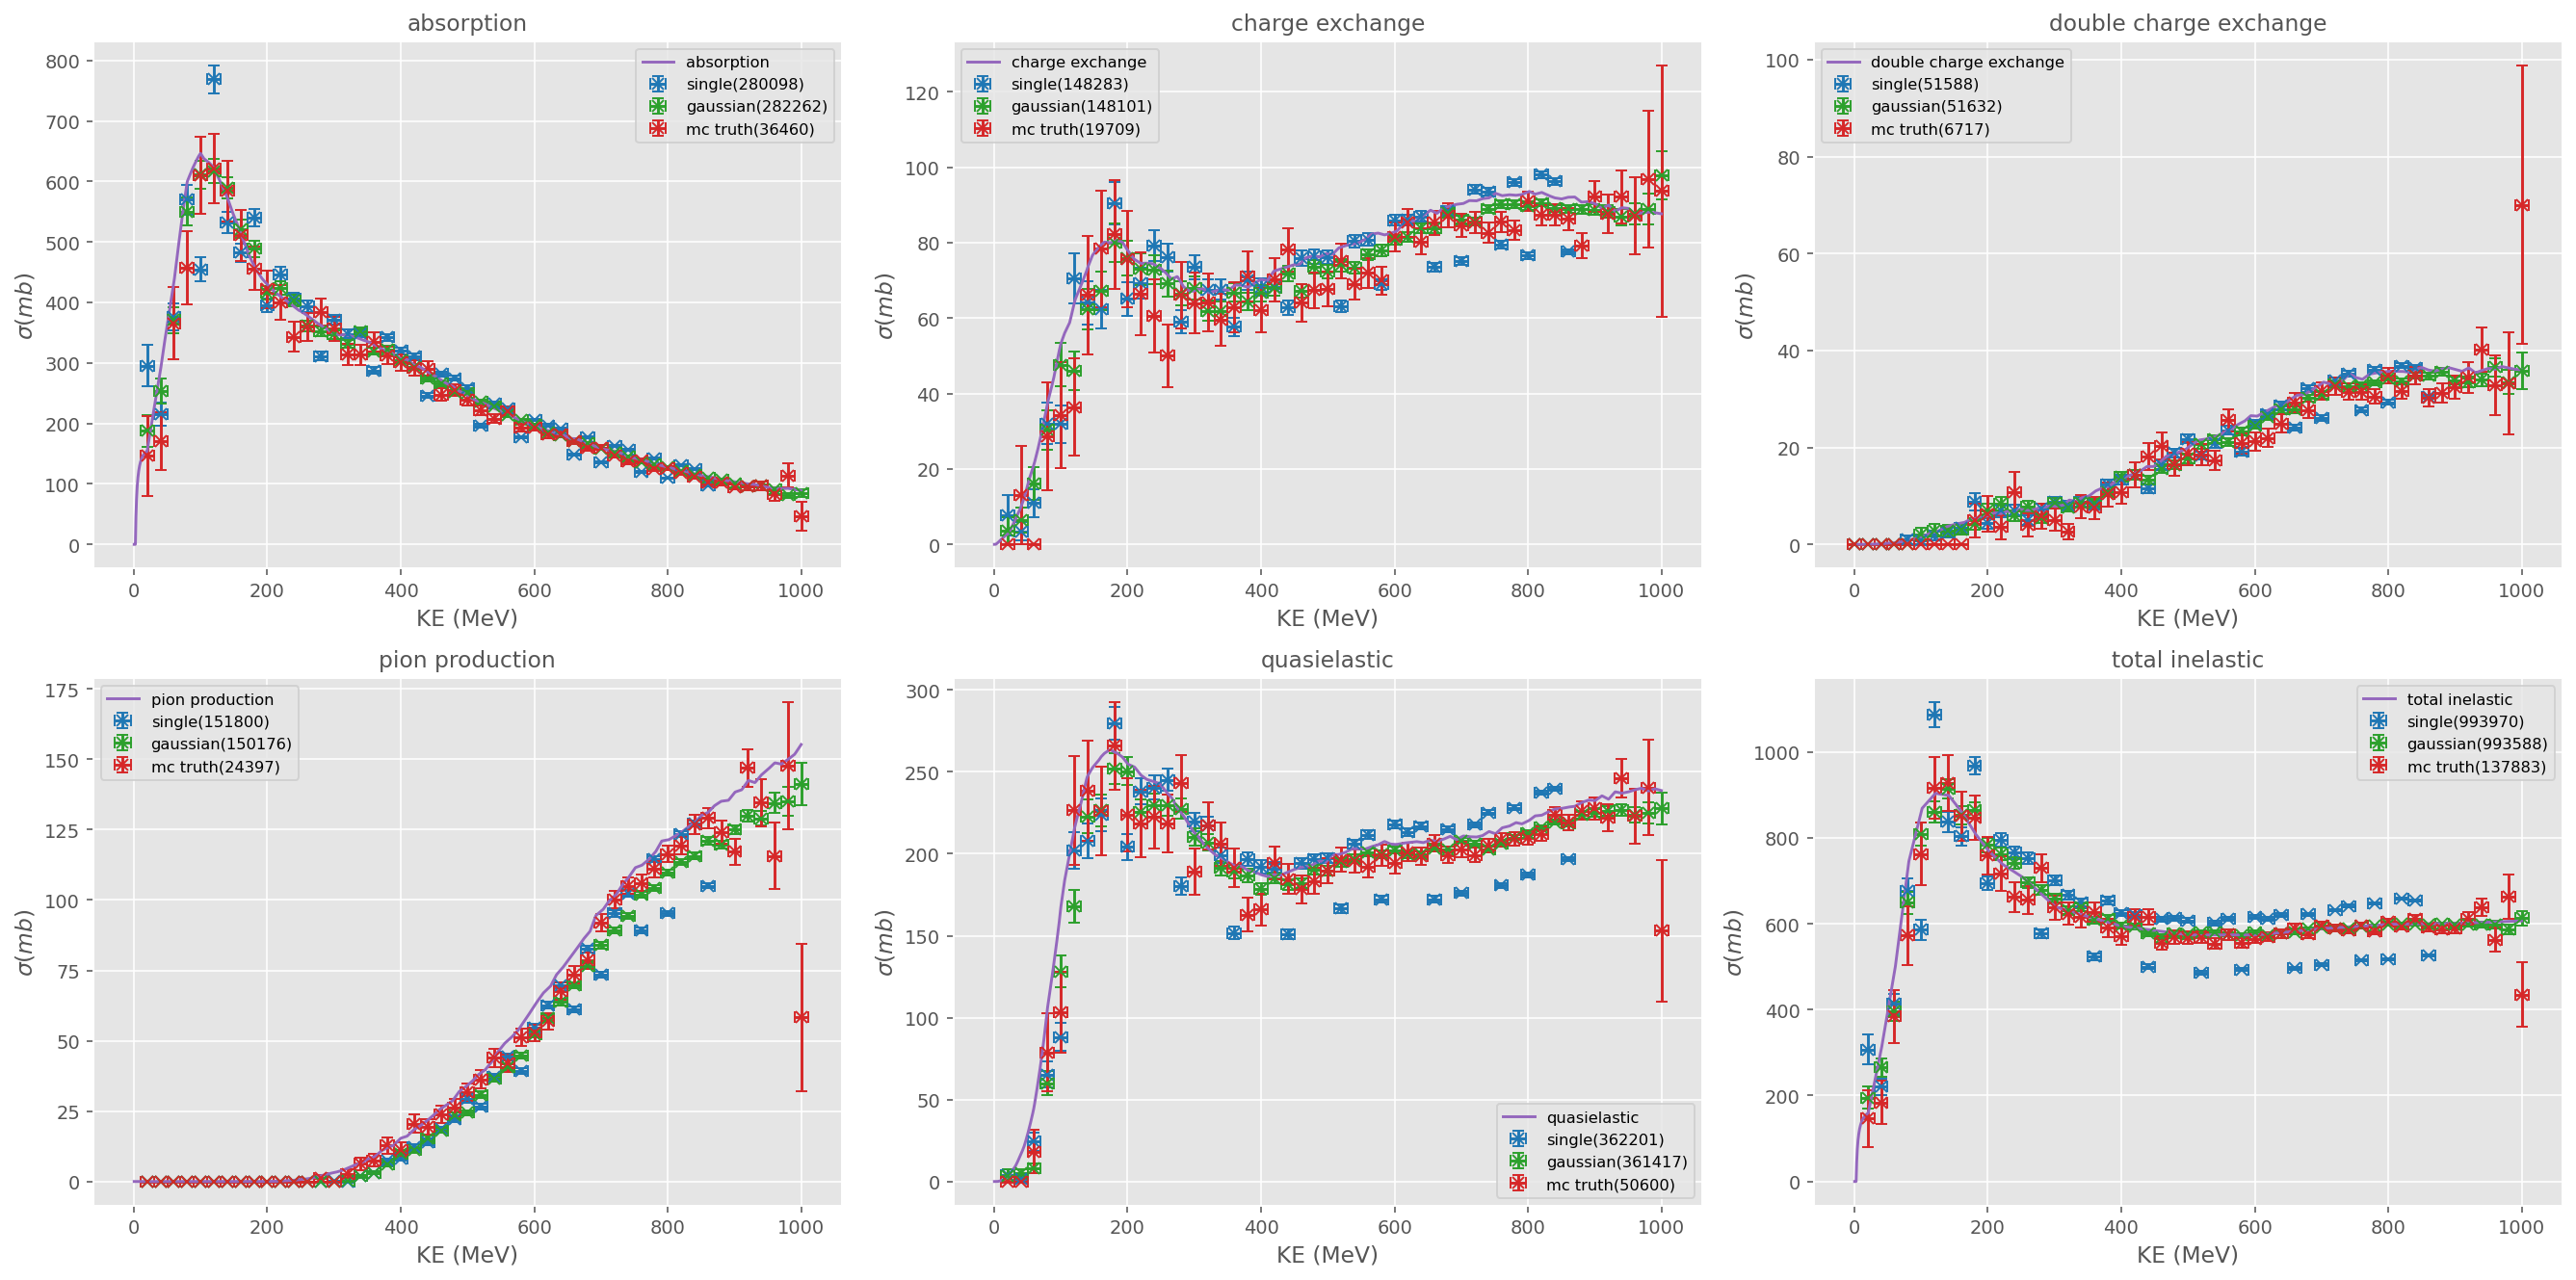

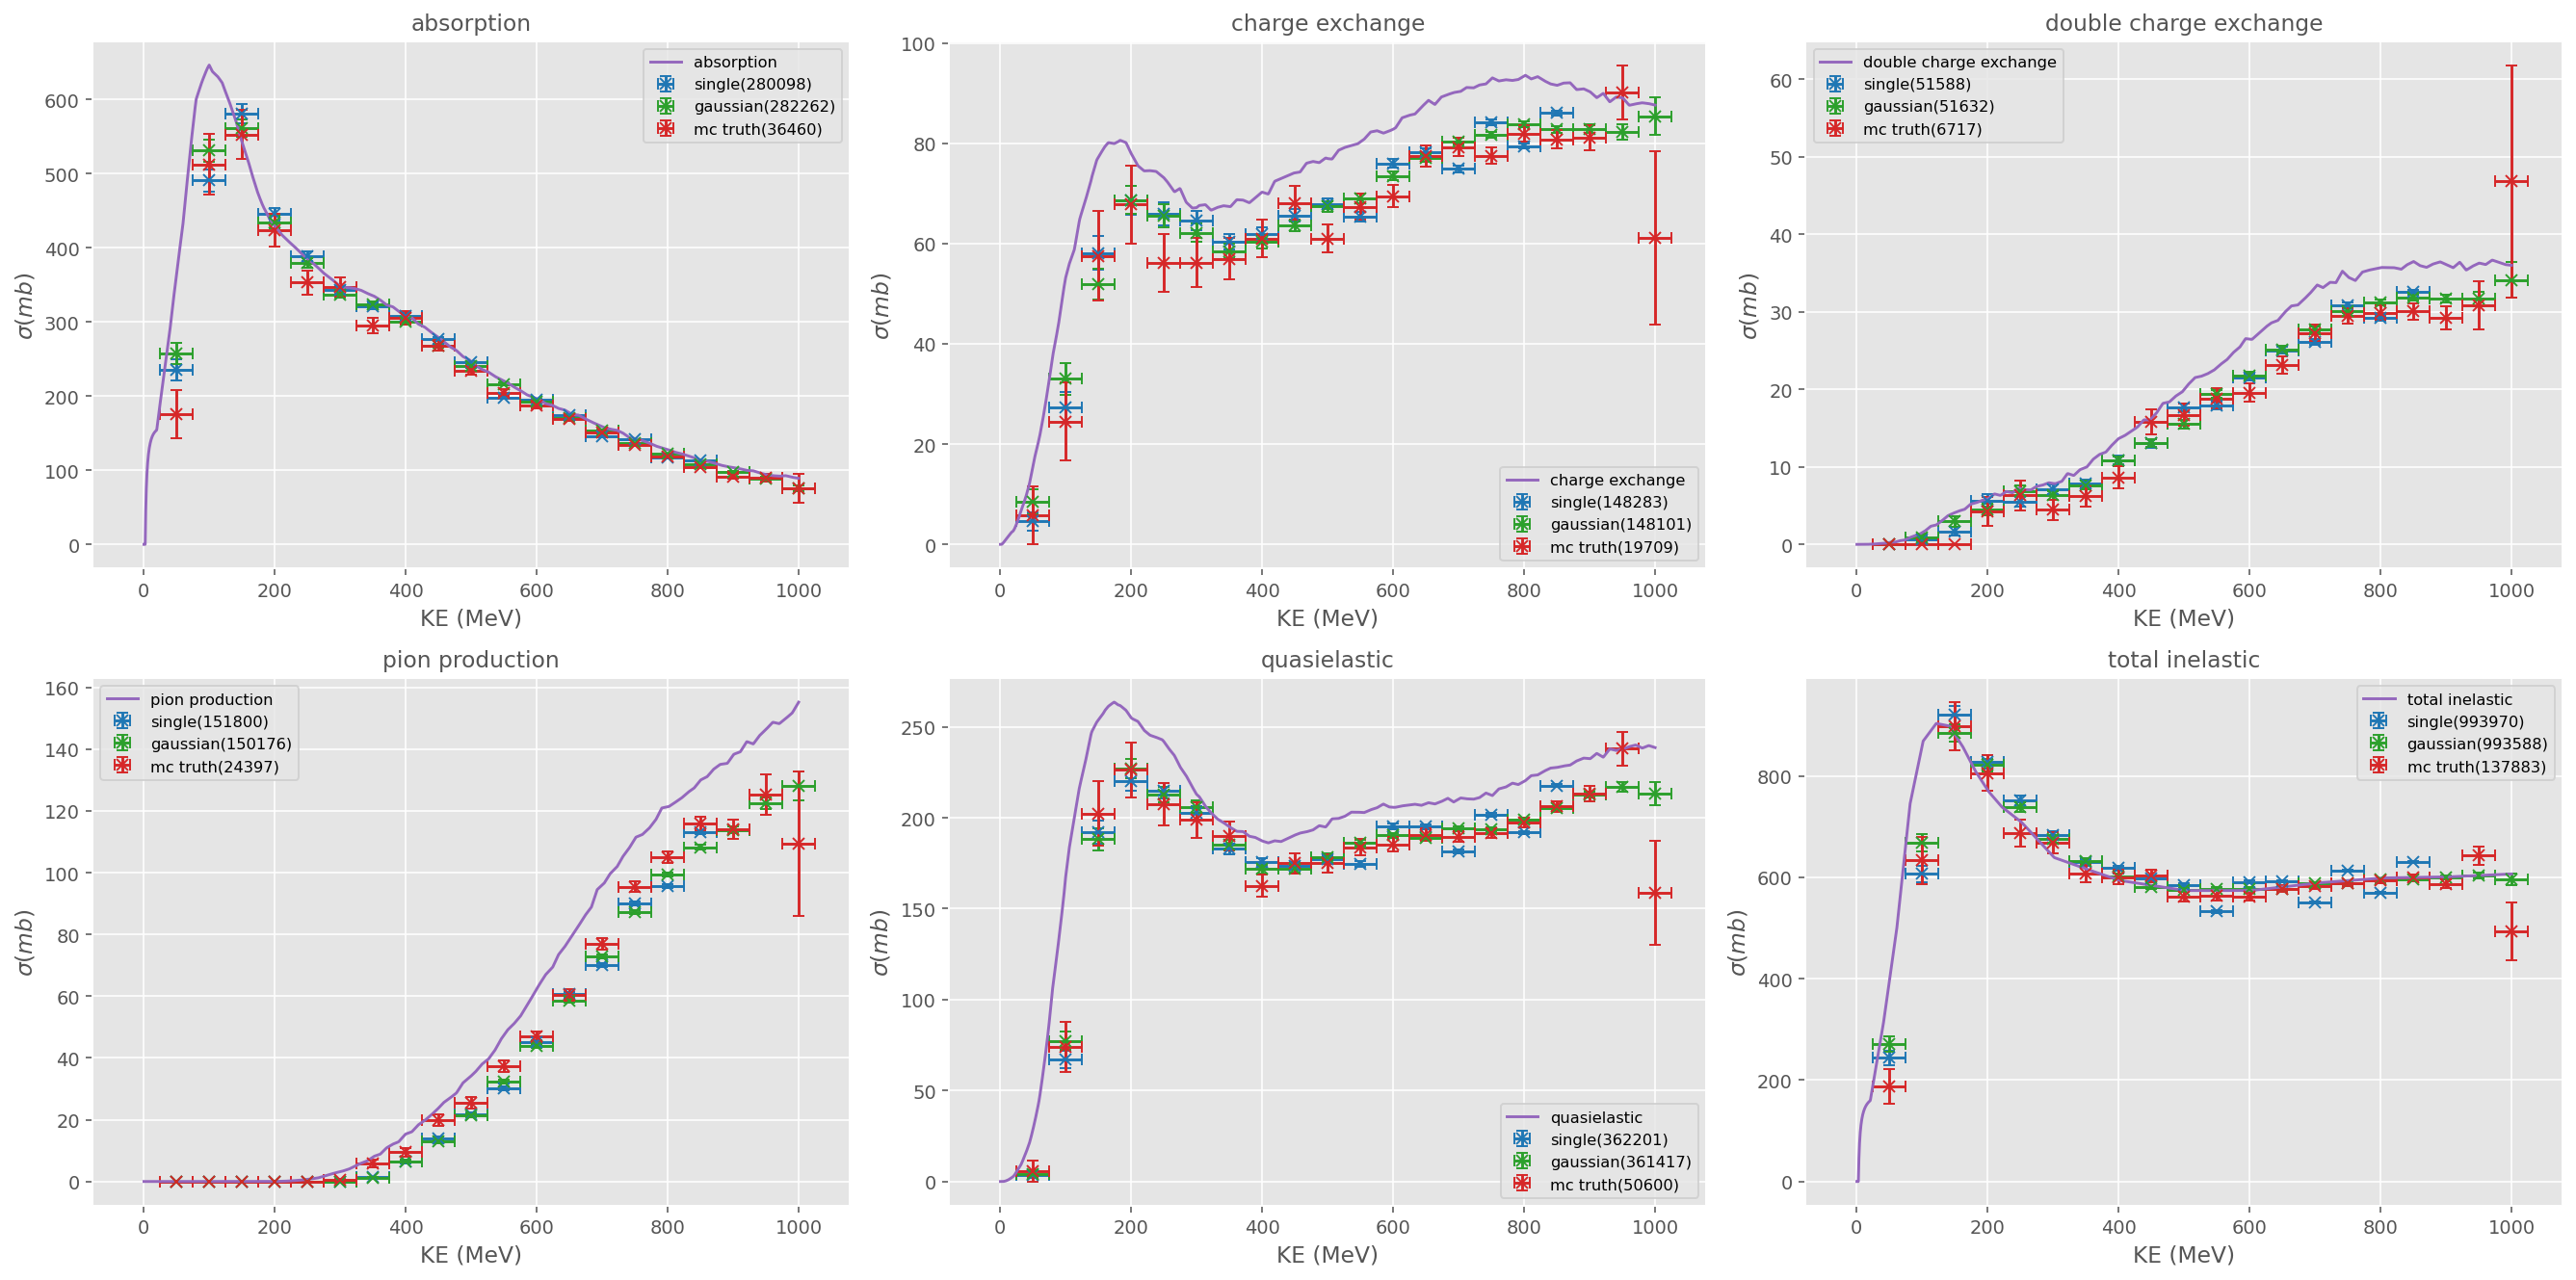

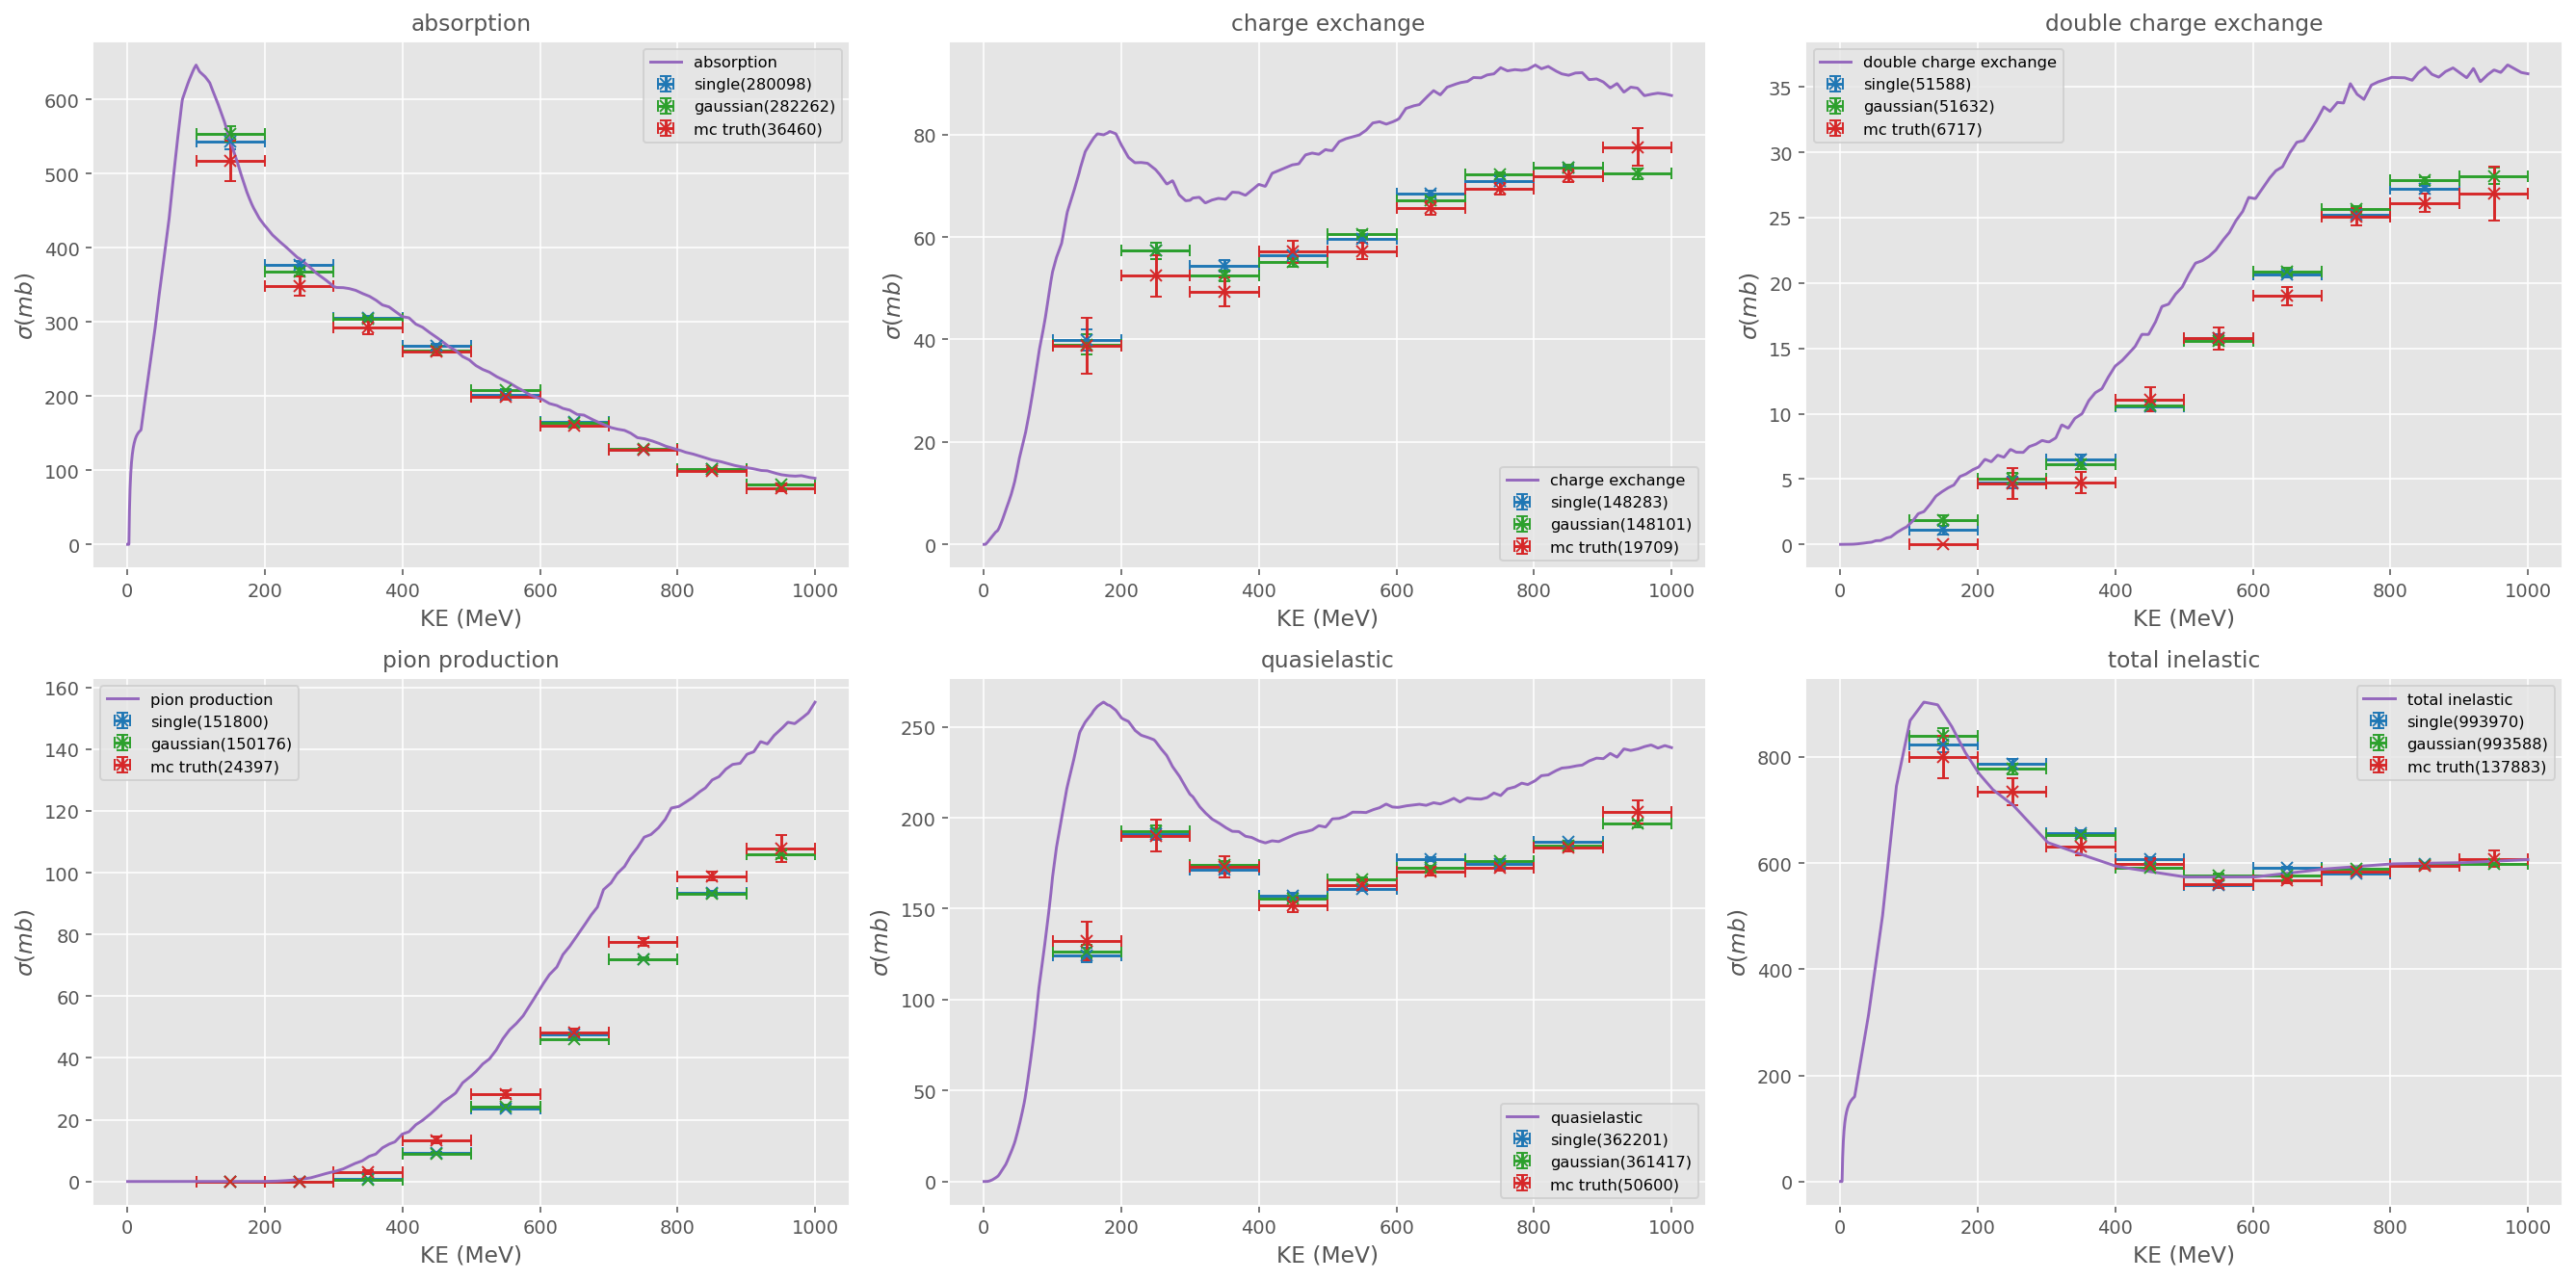

In [26]:
def ESliceComparison(slice_width : float, energy_range : list):
    """ Compares energy slice method for the single profile toy, gaussian profile toy and mc truth.

    Args:
        slice_width (float): energy slice width (MeV)
        energy_range (list): energy range of slices (MeV)
    """
    energy_slices = cross_section.Slices(slice_width, min(energy_range), max(energy_range), reversed = True)
    slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))

    ind = ak.argmax(mc.trueParticles.beam_traj_pos.z > 0, -1, keepdims = True)
    true_ffKE = ak.where(ak.flatten(mc.trueParticles.beam_traj_pos.z[ind]) < 0, 999999, mc.trueParticles.KE_front_face) # set KE to 999999 if the particle didn't reach the TPC.

    colours = {
        "single" : "C0",
        "gaussian" : "C4",
        "mc truth" : "C6"
    }

    KE_int = {
        "single" : toy_single.KE_int,
        "gaussian" : toy_gaussian.KE_int,
        "mc truth" : mc.trueParticles.beam_traj_KE[:, -2]
    }

    KE_init = {
        "single" : toy_single.KE_init,
        "gaussian" : toy_gaussian.KE_init,
        "mc truth" : true_ffKE
    }

    outside = {
        "single" : toy_single.z_int < 0,
        "gaussian" : toy_gaussian.z_int < 0,
        "mc truth" : true_ffKE >= 999999
    }

    sample_masks = {
        "single" : masks_single,
        "gaussian" : masks_gaussian,
        "mc truth" : regions
    }

    for i, c in Plots.IterMultiPlot(masks_single, sharex = True):

        counts = {
            "single" : sum(masks_single[c]),
            "gaussian" : sum(masks_gaussian[c]),
            "mc truth" : sum(regions[c])
        }

        geant_xs.Plot(c, color = "C8")
        hists = {s : cross_section.EnergySlice.CountingExperiment(KE_int[s], KE_init[s], outside[s], sample_masks[s][c], energy_slices) for s in KE_int}
        xs = {h : cross_section.EnergySlice.CrossSection(hists[h][0], hists[h][1], slice_dEdX, energy_slices.width) for h in hists}
        # n_interact, n_incident = cross_section.EnergySlice.CountingExperiment(toy_mc.KE_int, toy_mc.KE_init, toy_mc.z_int < 0, masks[c], energy_slices)
        for h in hists:
            Plots.Plot(energy_slices.pos[1:], xs[h][0][1:], xerr = energy_slices.width/2, yerr = xs[h][1][1:], marker = "x", linestyle = "", newFigure = False, label = f"{h}({counts[h]})", title = c.replace("_", " "), color = colours[h])
    Save()
    return

ESliceComparison(20, [0, 1020])
ESliceComparison(50, [0, 1050])
ESliceComparison(100, [0, 1050])

# Slice width study

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:575: RuntimeWarning: divide by zero encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:578: RuntimeWarning: divide by zero encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:580: RuntimeWarning: invalid value encountered in multiply
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in multiply
  result = getattr(ufunc, method)(


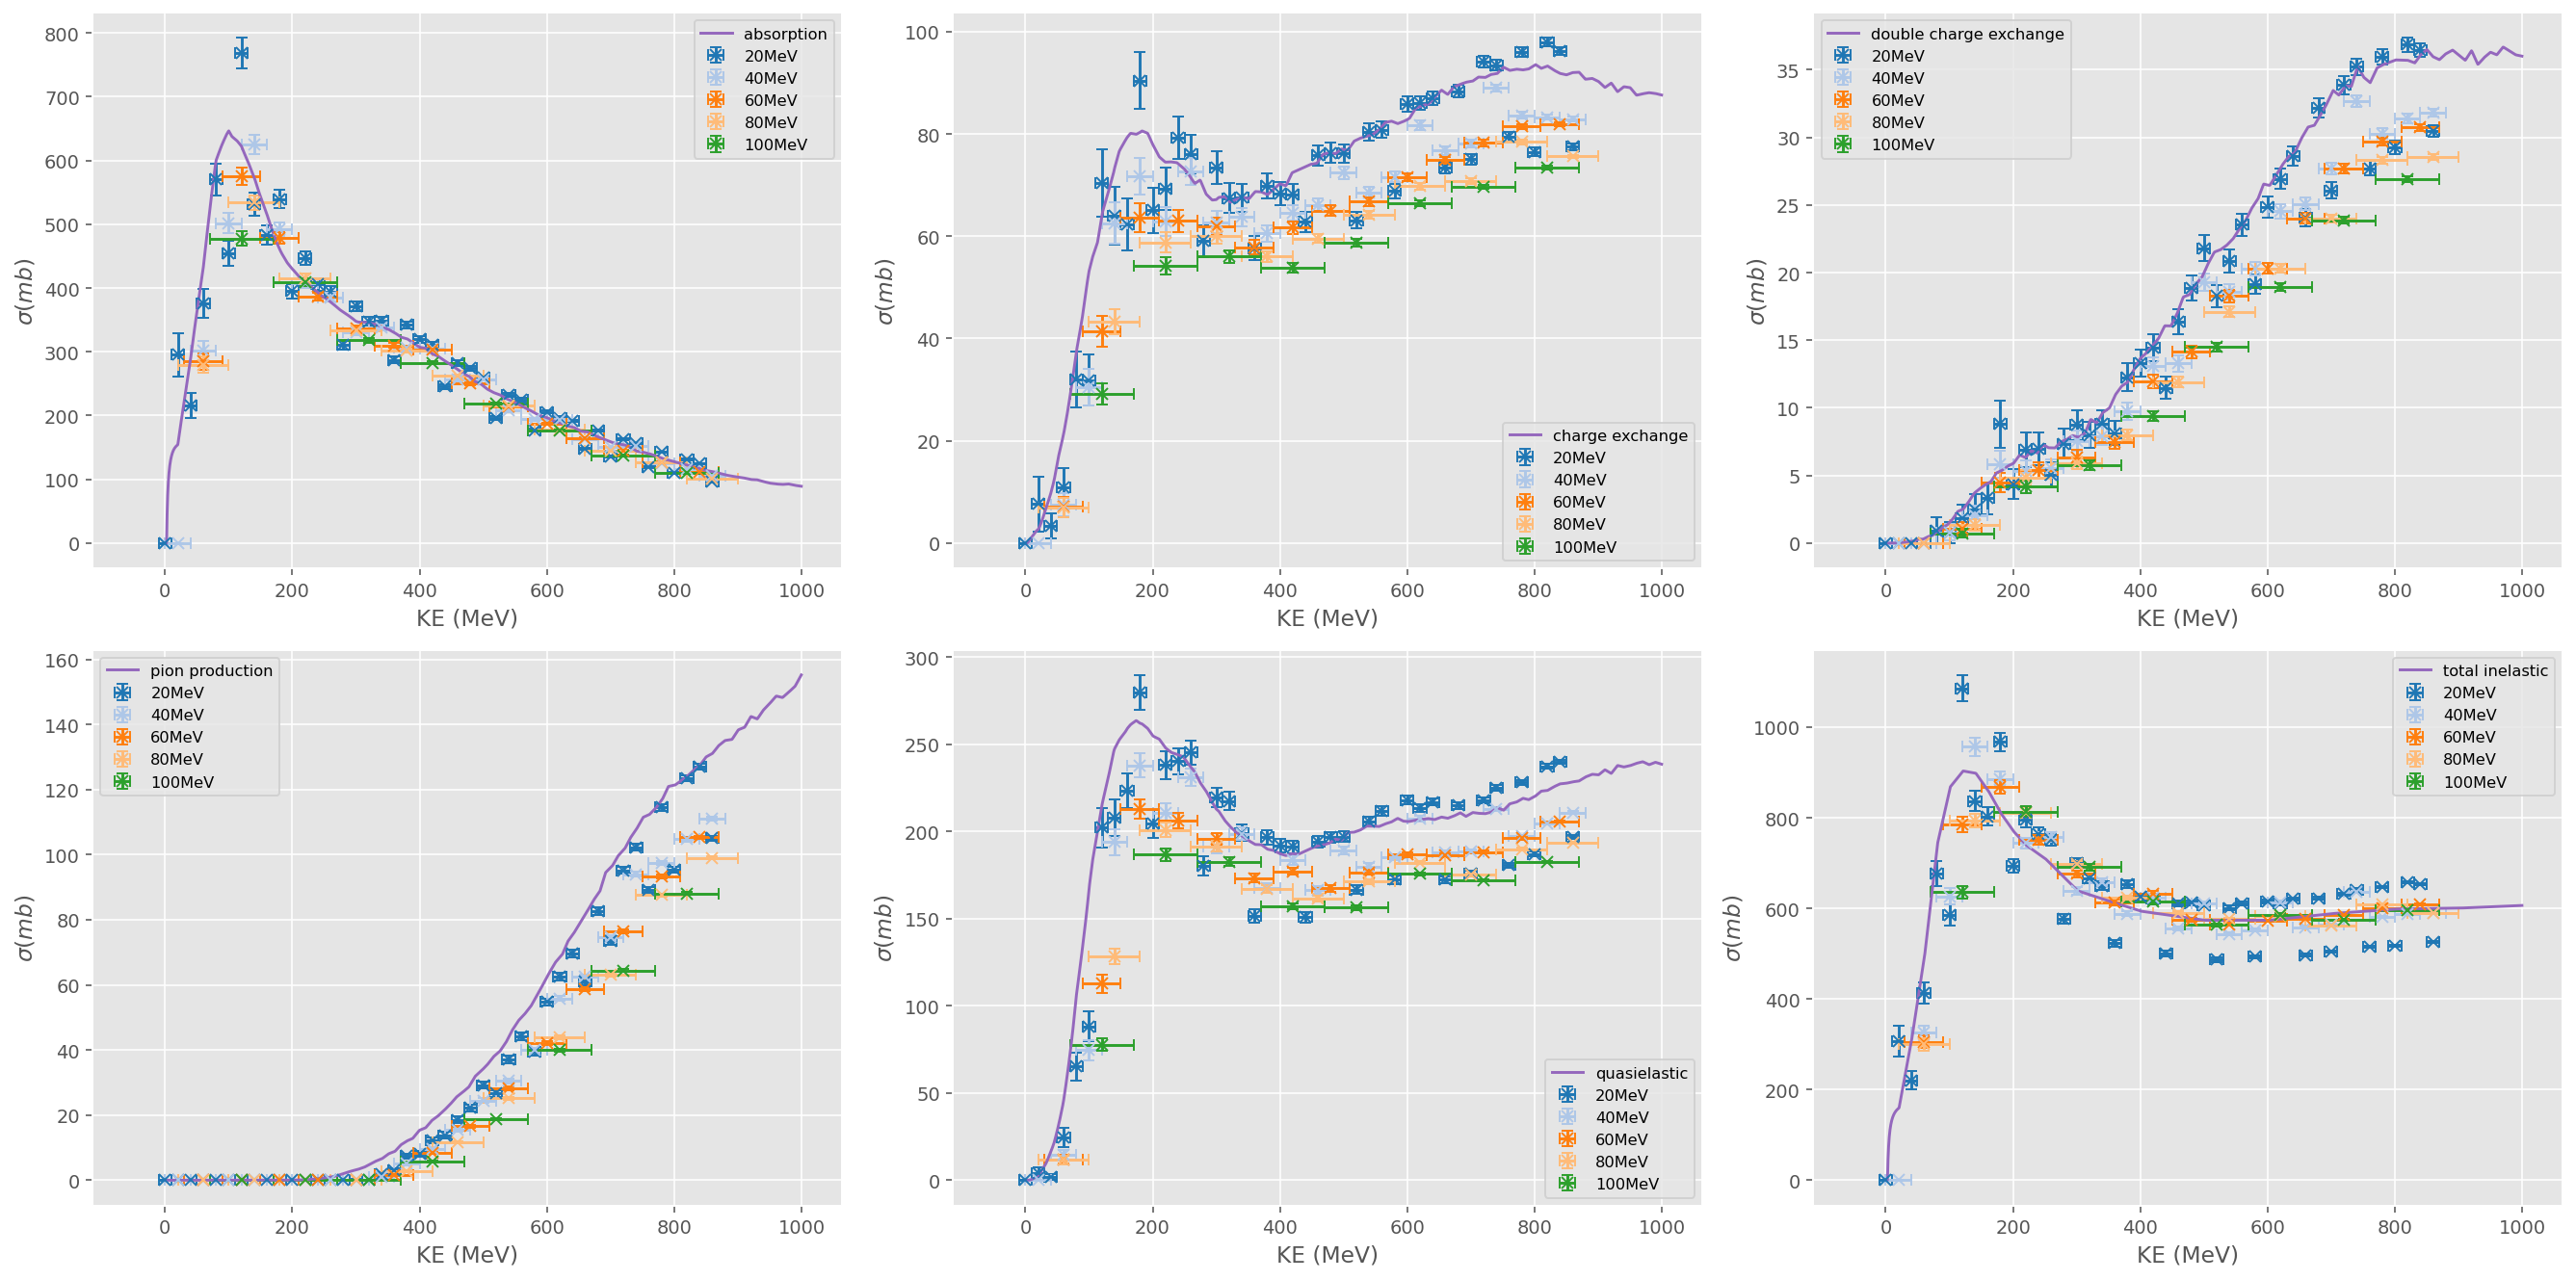

In [27]:
def ESliceWidth(slice_widths : float, energy_range : list):
    """ See how cross section varies as a function of slice thickness, using the single profile toy.

    Args:
        slice_width (float): energy slice width (MeV)
        energy_range (list): energy range of slices (MeV)
    """
    energy_slices = []
    slice_dEdX = []
    for s in slice_widths:
        energy_slices.append(cross_section.Slices(s, min(energy_range), max(energy_range), reversed = True))
        slice_dEdX.append(cross_section.EnergySlice.Slice_dEdX(energy_slices[-1], cross_section.Particle.from_pdgid(211)))

    for _, c in Plots.IterMultiPlot(masks_single):
        hists = [cross_section.EnergySlice.CountingExperiment(toy_single.KE_int, toy_single.KE_init, toy_single.z_int < 0, masks_single[c], energy_slices[i]) for i in range(len(slice_widths))]
        xs = [cross_section.EnergySlice.CrossSection(*hists[i], slice_dEdX[i], energy_slices[i].width) for i in range(len(slice_widths))]

        geant_xs.Plot(c, color = "C8")
        for i in range(len(slice_widths)):
            Plots.Plot(energy_slices[i].pos[1:], xs[i][0][1:], xerr = energy_slices[i].width/2, yerr = xs[i][1][1:], marker = "x", linestyle = "", newFigure = False, label = f"{slice_widths[i]}MeV")
    Save()
    return

ESliceWidth([20, 40, 60, 80, 100], [-20, 1020])

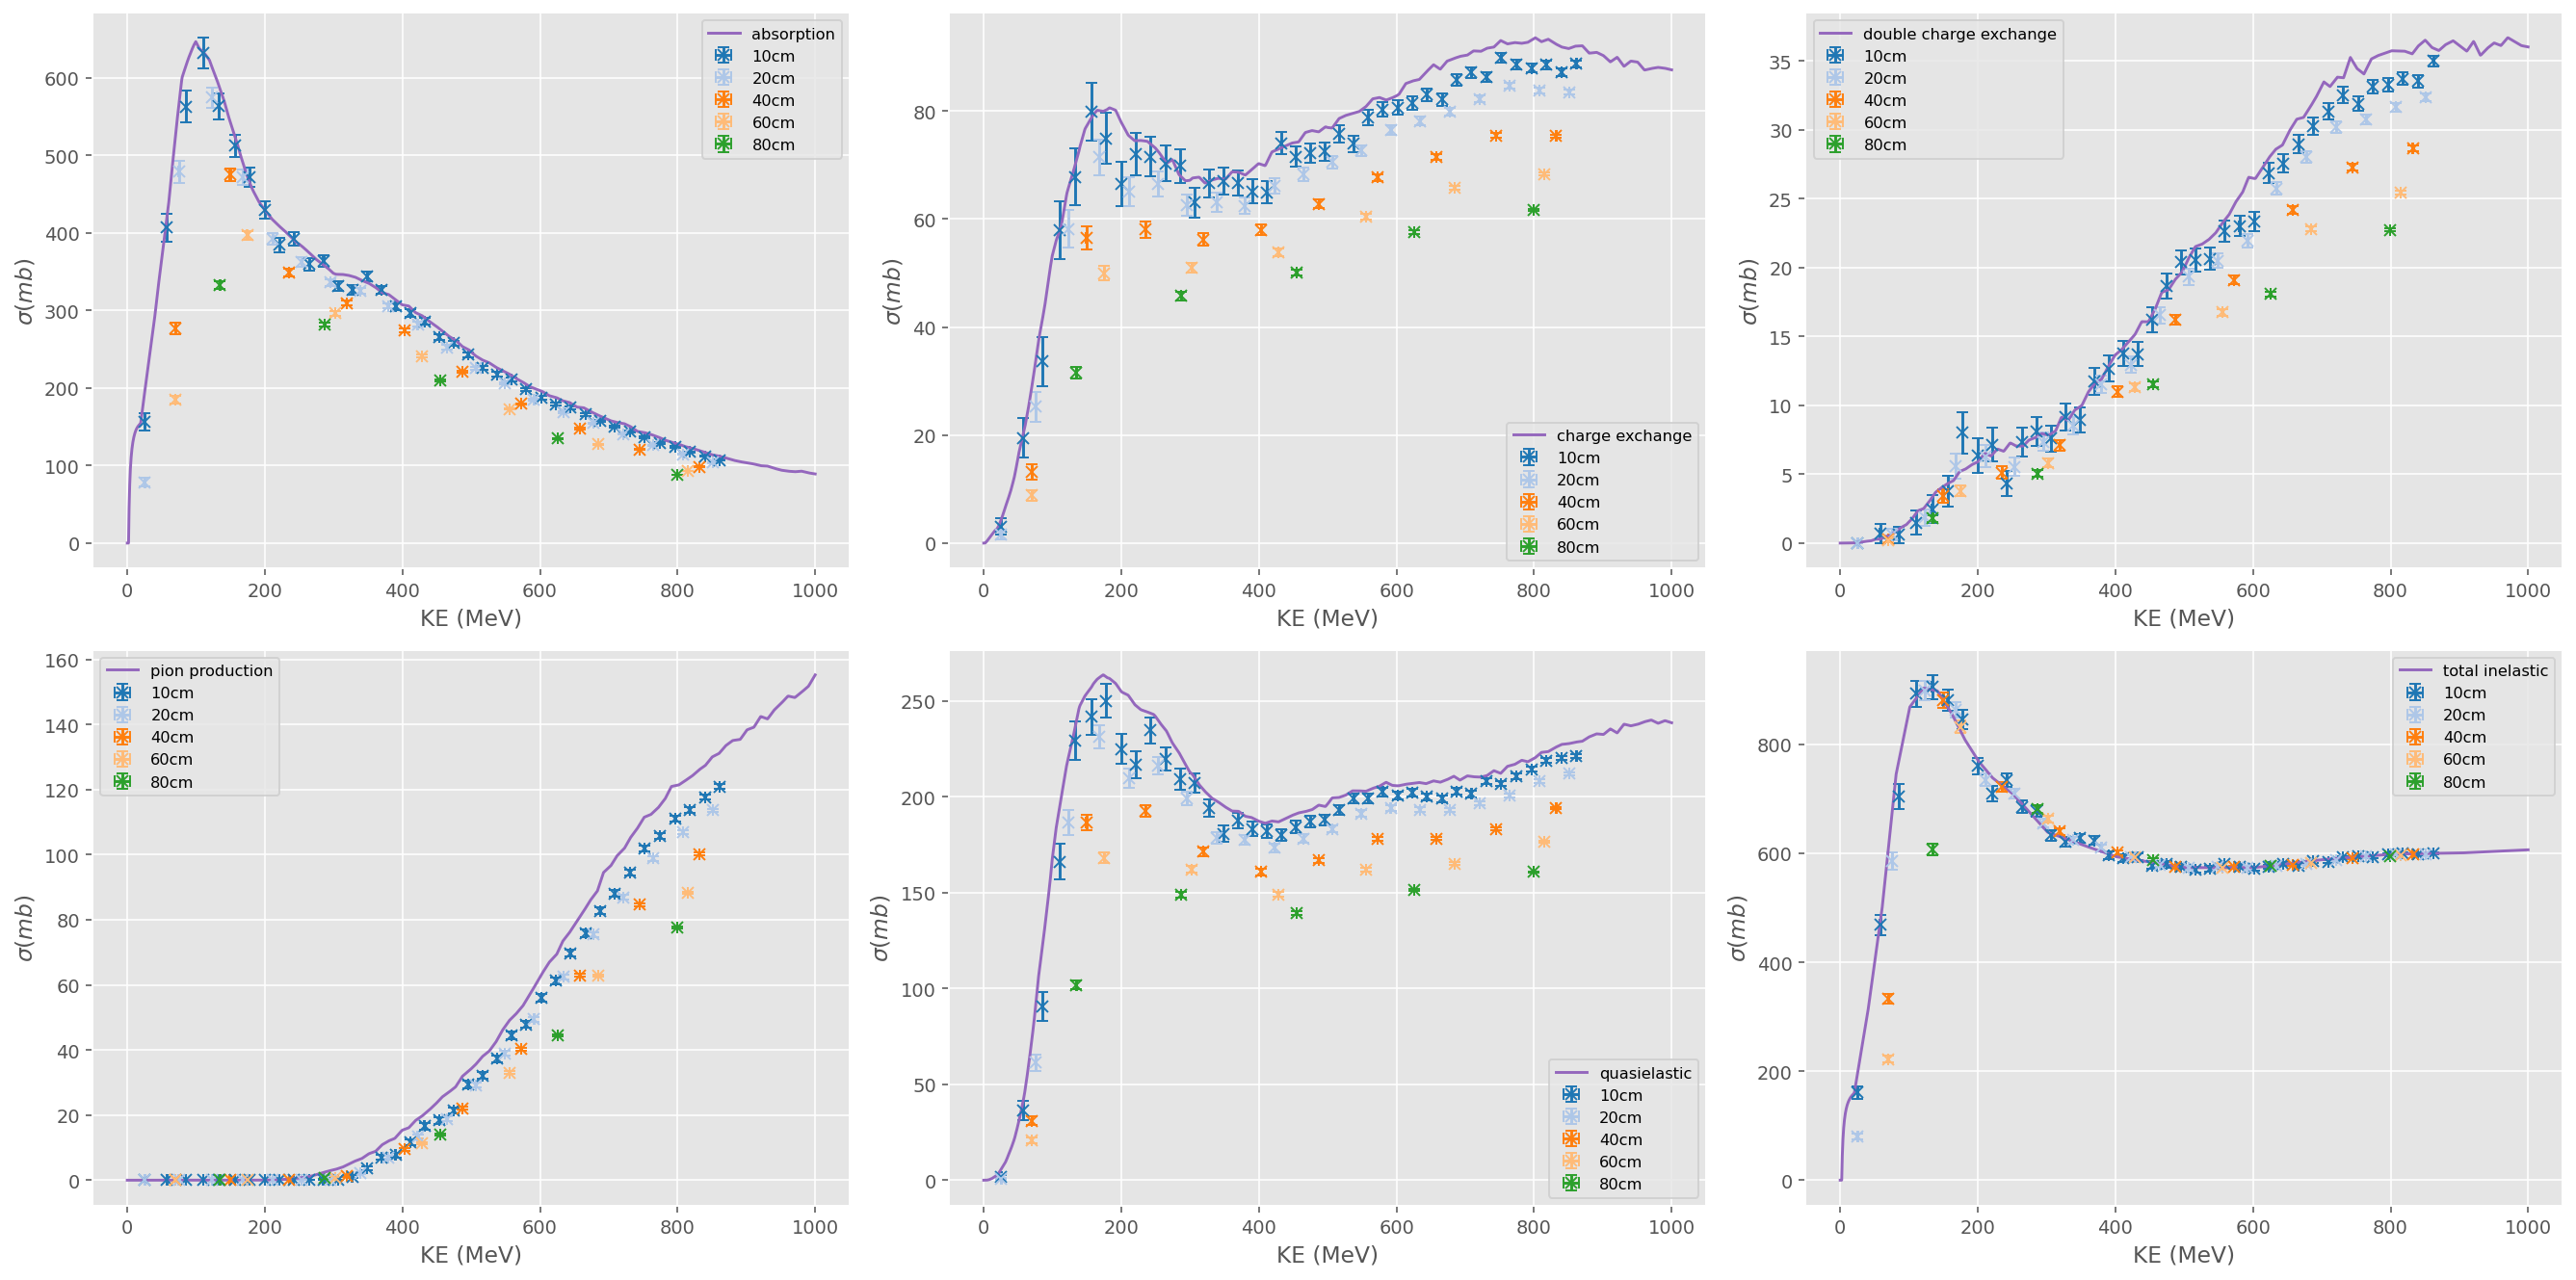

In [28]:
def ThinSliceWitdh(slice_widths : float, position_range : list):
    """ See how cross section varies as a function of slice thickness, using the single profile toy.

    Args:
        slice_width (float): spatial slice width (cm)
        position_range (list): min, max position for slices (cm)
    """
    slices = []
    mean_energy = []
    decayed = toy_single.inclusive_process == "decay"
    for s in slice_widths:
        slices.append(cross_section.Slices(s, min(position_range), max(position_range)))
        mean_energy.append(cross_section.ThinSlice.MeanSliceEnergy(toy_single.KE_int[~decayed], toy_single.z_int[~decayed], slices[-1]))

    for _, c in Plots.IterMultiPlot(masks_single):
        hists = [cross_section.ThinSlice.CountingExperiment(toy_single.z_int, masks_single[c], slices[i]) for i in range(len(slice_widths))]
        xs = [cross_section.ThinSlice.CrossSection(hists[i][1], hists[i][0], slices[i].width) for i in range(len(slice_widths))]

        geant_xs.Plot(c, color = "C8")
        for i in range(len(slice_widths)):
            Plots.Plot(mean_energy[i][0], xs[i][0], xerr = mean_energy[i][1], yerr = xs[i][1], marker = "x", linestyle = "", newFigure = False, label = f"{slice_widths[i]}cm")
    Save()
    return

ThinSliceWitdh([10, 20, 40, 60, 80], [-10, 720])

In [29]:
pdf.close()

In [30]:
def PlotMeanEnergies(pos : np.array, energy : np.array, slices : cross_section.Slices, range : list = None):
    """ Plot energies in each spatial slice in a giant subplot

    Args:
        pos (np.array): position
        energy (np.array): kinetic energy
        slices (cross_section.Slices): spatial slices
        range (list, optional): energy range. Defaults to None.
    """
    for _, s in Plots.IterMultiPlot(list(slices)):
        mask = slices.pos_to_num(pos) == s.num
        e = energy[mask]
        if len(e) == 0:
            plt.gcf().delaxes(plt.gca())
            continue
        Plots.PlotHist(e, title = s.__str__(), range = range, xlabel = "$KE^{true}_{int}$ (MeV)", newFigure = False)


def PlotMeanEnergiesSplit(pos : np.array, energy : np.array, slices : cross_section.Slices, range : list = None):
    """ Plot energies in each spatial slice in it's own figure, and save to a pdf file.

    Args:
        pos (np.array): position
        energy (np.array): kinetic energy
        slices (cross_section.Slices): spatial slices
        range (list, optional): energy range. Defaults to None.
    """
    pdf = PdfPages("gaussian_toy_energy_bins.pdf")
    for s in list(slices):
        mask = slices.pos_to_num(pos) == s.num
        e = energy[mask]
        if len(e) == 0: continue
        Plots.PlotHist(e, title = s.__str__(), range = range, xlabel = "$KE^{true}_{int}$ (MeV)")
        pdf.savefig()
        plt.close() # still causes the plot to be rendered in the terminal output.
    pdf.close()

In [31]:
# PlotMeanEnergiesSplit(toy_single.z_int, toy_single.KE_int, cross_section.Slices(10, -10, 720))

# Encorperating particle decays

particles have essentially three options when passing through a thin target:
 1. interact with the material inelastically
 2. pass through (this includes elasitc sccatters)
 3. decay

if we treat elastic scatters as essentially no interaction, then just sampling from the inelastic PDF covers the first two cases, but not the third. In order to do the third, try the following:
 1. for each particle, compute a lifetime at the start of the simulation, this can be done with the typical exponential decay of particles and the particle lifetime in the pdg database
 2. keep track of each particles time as it passes through the TPC, note this muse be done for each particle separately as we allow distributions of kinetic energy. This is done at each thin target using the relation to $\beta$ and $KE$ derived below
 3. if the particles current time exceeds it's lifetime, classify it as decayed i.e. it did not survive.

Including this affect should lower the number of interactions at the low energy regime and thus elminate this issue of the cross section diverging. Note this means we need to also keep track of $\beta$ as the particle looses energy in each slice.

## Derivation of $\beta$
$$ KE = \sqrt{p^{2} + m^{2}} - m = \sqrt{(m\beta\gamma)^{2} + m^{2}} - m = \sqrt{\left(\frac{m\beta}{\sqrt{1 - \beta^{2}}}\right)^{2} + m^{2}} = \sqrt{\frac{m^{2}\beta^{2}}{1 - \beta^{2}} + m^{2}} = m\sqrt{\frac{\beta^{2}}{1 - \beta^{2}} + 1} $$

$$ \left(\frac{KE}{m}\right)^{2} - 1 = \frac{\beta^{2}}{1 - \beta^{2}} $$

$$ \beta^{2} = \left(\left(\frac{KE}{m}\right)^{2} - 1\right)\left(1 - \beta^{2}\right) = \left(\left(\frac{KE}{m}\right)^{2} - 1\right) - \left(\left(\frac{KE}{m}\right)^{2} - 1\right)\beta^{2} $$

$$ \left(\frac{KE}{m}\right)^{2} - 1 = \beta^{2} + \left(\left(\frac{KE}{m}\right)^{2} - 1\right)\beta^{2} = \left(\frac{KE}{m}\right)^{2}\beta^{2} $$

$$ \beta^{2} = \frac{\left(\frac{KE}{m}\right)^{2} - 1 }{ \left(\frac{KE}{m}\right)^{2} }$$

$$\therefore \beta = \sqrt{1 - \frac{1}{ \left(\frac{KE}{m}\right)^{2} }} $$


## Particle lifetime
$$ N(t) = N_{0} e^{-\frac{t}{\tau}} $$

$$ P_{decay} = e^{-\frac{t}{\tau}} $$

$$\ln\left( P_{decay} \right) = -\frac{t}{tau} $$

$$ t = -\tau\ln\left( P_{decay} \right) $$

So, sample from a random uniform distribution to get $P_{int}$

## Time elapsed at current slice
$$ t_{elapsed} = l \beta $$